In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 26 16:09:11 2017

@author: cbothore
"""


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter
# import community as co

# 定义社交网络图

In [3]:
def properties(g):
    """
    Computes simple and classic graph metrics.

    Parameters
    ----------
    g : graph
       A networkx graph
    """
    # networkx short summary of information for the graph g
    print(nx.info(g))
    
    # Draw the degree distribution. Powerlow distribution for a real (complex) network
    plt.figure(num=None)
    fig = plt.figure(1)
    degree_sequence=[d for n, d in g.degree()] # degree sequence
    print("Degree sequence %s" % degree_sequence)
    plt.hist(degree_sequence, bins='auto')  
    plt.title("powerlaw degree distribution")
    plt.ylabel("# nodes")
    plt.xlabel("degree")
    plt.show()
    pylab.close()
    del fig
    
# 偏心率：节点A的偏心率被定义为A和所有其他节点之间的最大距离。 可以使用nx.eccentricity（）函数找到它。 
# 如果偏心率为1，则他与所有人相连
    precomputed_eccentricity = nx.eccentricity(g) # costly step, we save time here!
    print("Graph density %f" % nx.density(g))
    print("Diameter (maximum eccentricity): %d" % nx.diameter(g,precomputed_eccentricity))
    print("Radius (minimum eccentricity): %d" % nx.radius(g,precomputed_eccentricity)) #The radius is the minimum eccentricity.
    print("Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): %s" % np.mean(list(precomputed_eccentricity.values())))
    print("Center is composed of %d nodes (nodes with eccentricity equal to radius)" % len(nx.center(g, precomputed_eccentricity)))
    print("Periphery is composed of %d nodes (nodes with eccentricity equal to the diameter)" % len(nx.periphery(g,precomputed_eccentricity)))
    
# 聚类系数：据观察，在社交网络中共享联系的人倾向于形成关联。换句话说，社交网络中存在形成集群的趋势。
# 我们可以确定节点的集群，Local Clustering Coefficient，它是节点的朋友（即连接）彼此连接的对的一部分。
# 为了确定局部聚类系数，我们使用nx.clustering（Graph，Node）函数。
    print("Mean clustering coefficient %f" % np.mean(list(nx.clustering(g).values())))
    total_triangles=sum(nx.triangles(g).values())/3    
    print("Total number of triangles in graph: %d" % total_triangles)

 # 信息补充方法

In [4]:
def naive_method(graph, empty, attr):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    attr : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values

# 准确率定义 （正确预测的个数占总预测值的比例）

In [5]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth :  : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0   
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction+=1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])          
        # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/(sum(len(v) for v in pred.values()))
   



In [6]:
# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")
print("Nb of users in our graph: %d" % len(G))

# load the profiles. 3 files for each type of attribute
# Some nodes in G have no attributes
# Some nodes may have 1 attribute 'location'
# Some nodes may have 1 or more 'colleges' or 'employers', so we
# use dictionaries to store the attributes
college={}
location={}
employer={}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)

print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))

# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes=[]
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)
print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))


# --------------------- Baseline method -------------------------------------#
# Try a naive method to predict attribute
# This will be a baseline method for you, i.e. you will compare your performance
# with this method
# Let's try with the attribute 'employer'


employer_predictions=naive_method(G, empty_nodes, employer)
location_predictions=naive_method(G, empty_nodes, location)
college_predictions=naive_method(G, empty_nodes, college)
groundtruth_employer={}
groundtruth_location={}
groundtruth_college={}
with open('mediumEmployer.pickle', 'rb') as handle:
    groundtruth_employer = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
with open('mediumCollege.pickle', 'rb') as handle:
    groundtruth_college = pickle.load(handle)
    
    
result_employer=evaluation_accuracy(groundtruth_employer,employer_predictions)
print("%f%% of the predictions are true" % result_employer)

result_location=evaluation_accuracy(groundtruth_location,location_predictions)
print("%f%% of the predictions are true" % result_location)

result_college=evaluation_accuracy(groundtruth_college,college_predictions)
print("%f%% of the predictions are true" % result_college)

print("Very poor result!!! Try to do better!!!!")

Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
19.696970% of the predictions are true
32.352941% of the predictions are true
28.404669% of the predictions are true
Very poor result!!! Try to do better!!!!


In [165]:
employer_predictions['U13995']

KeyError: 'U13995'

In [174]:
employer['U13995']

KeyError: 'U13995'

In [171]:
if 'U13995' in empty_nodes:
    print("fuck")
else:
    print("WTF")

WTF


In [172]:
len(list(employer.keys()))

297

In [167]:
employer

{'U1313': ['discovery education',
  'ctb mcgraw-hill',
  'university of charleston university of south carolina',
  'south carolina department of education',
  'chesapeake va and sumter sc',
  'virgina state corrections'],
 'U8804': ['gruppo euris spa',
  'iconsulting',
  'econoetica',
  'universit&#xe0; di bologna',
  'university of illinois at urbana-champaign'],
 'U2649': ['bocom international',
  'inventiv health',
  'glaxosmithkline plc',
  'zhongrong international trust co. ltd'],
 'U7310': ['microsoft',
  'illinois computer technology',
  'university of illinois at urbana-champaign',
  'state farm insurance'],
 'U22859': ['amazon',
  'ibm india research lab',
  'coordinated science lab',
  'toyota technical center'],
 'U1417': ['designing events'],
 'U25611': ['bluegranite', 'measured progress', 'sweetser'],
 'U3895': ['vertica systems an hp company',
  'morgan stanley',
  'microsoft',
  'google'],
 'U13005': ['illinois state university',
  'university of illinois at urbana-cham

In [6]:
with open('mediumCollege.pickle', 'rb') as handle:
    college_full = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    location_full = pickle.load(handle)
with open('mediumEmployer.pickle', 'rb') as handle:
    employer_full = pickle.load(handle)

In [7]:
print("Nb of users with one or more attribute college: %d" % len(college_full))
print("Nb of users with one or more attribute location: %d" % len(location_full))
print("Nb of users with one or more attribute employer: %d" % len(employer_full))


Nb of users with one or more attribute college: 540
Nb of users with one or more attribute location: 811
Nb of users with one or more attribute employer: 730


In [8]:
# --------------------- Now your turn -------------------------------------#
# Explore, implement your strategy to fill empty profiles of empty_nodes


# and compare with the ground truth (what you should have predicted)
# user precision and recall measures

# lulu's challenge!

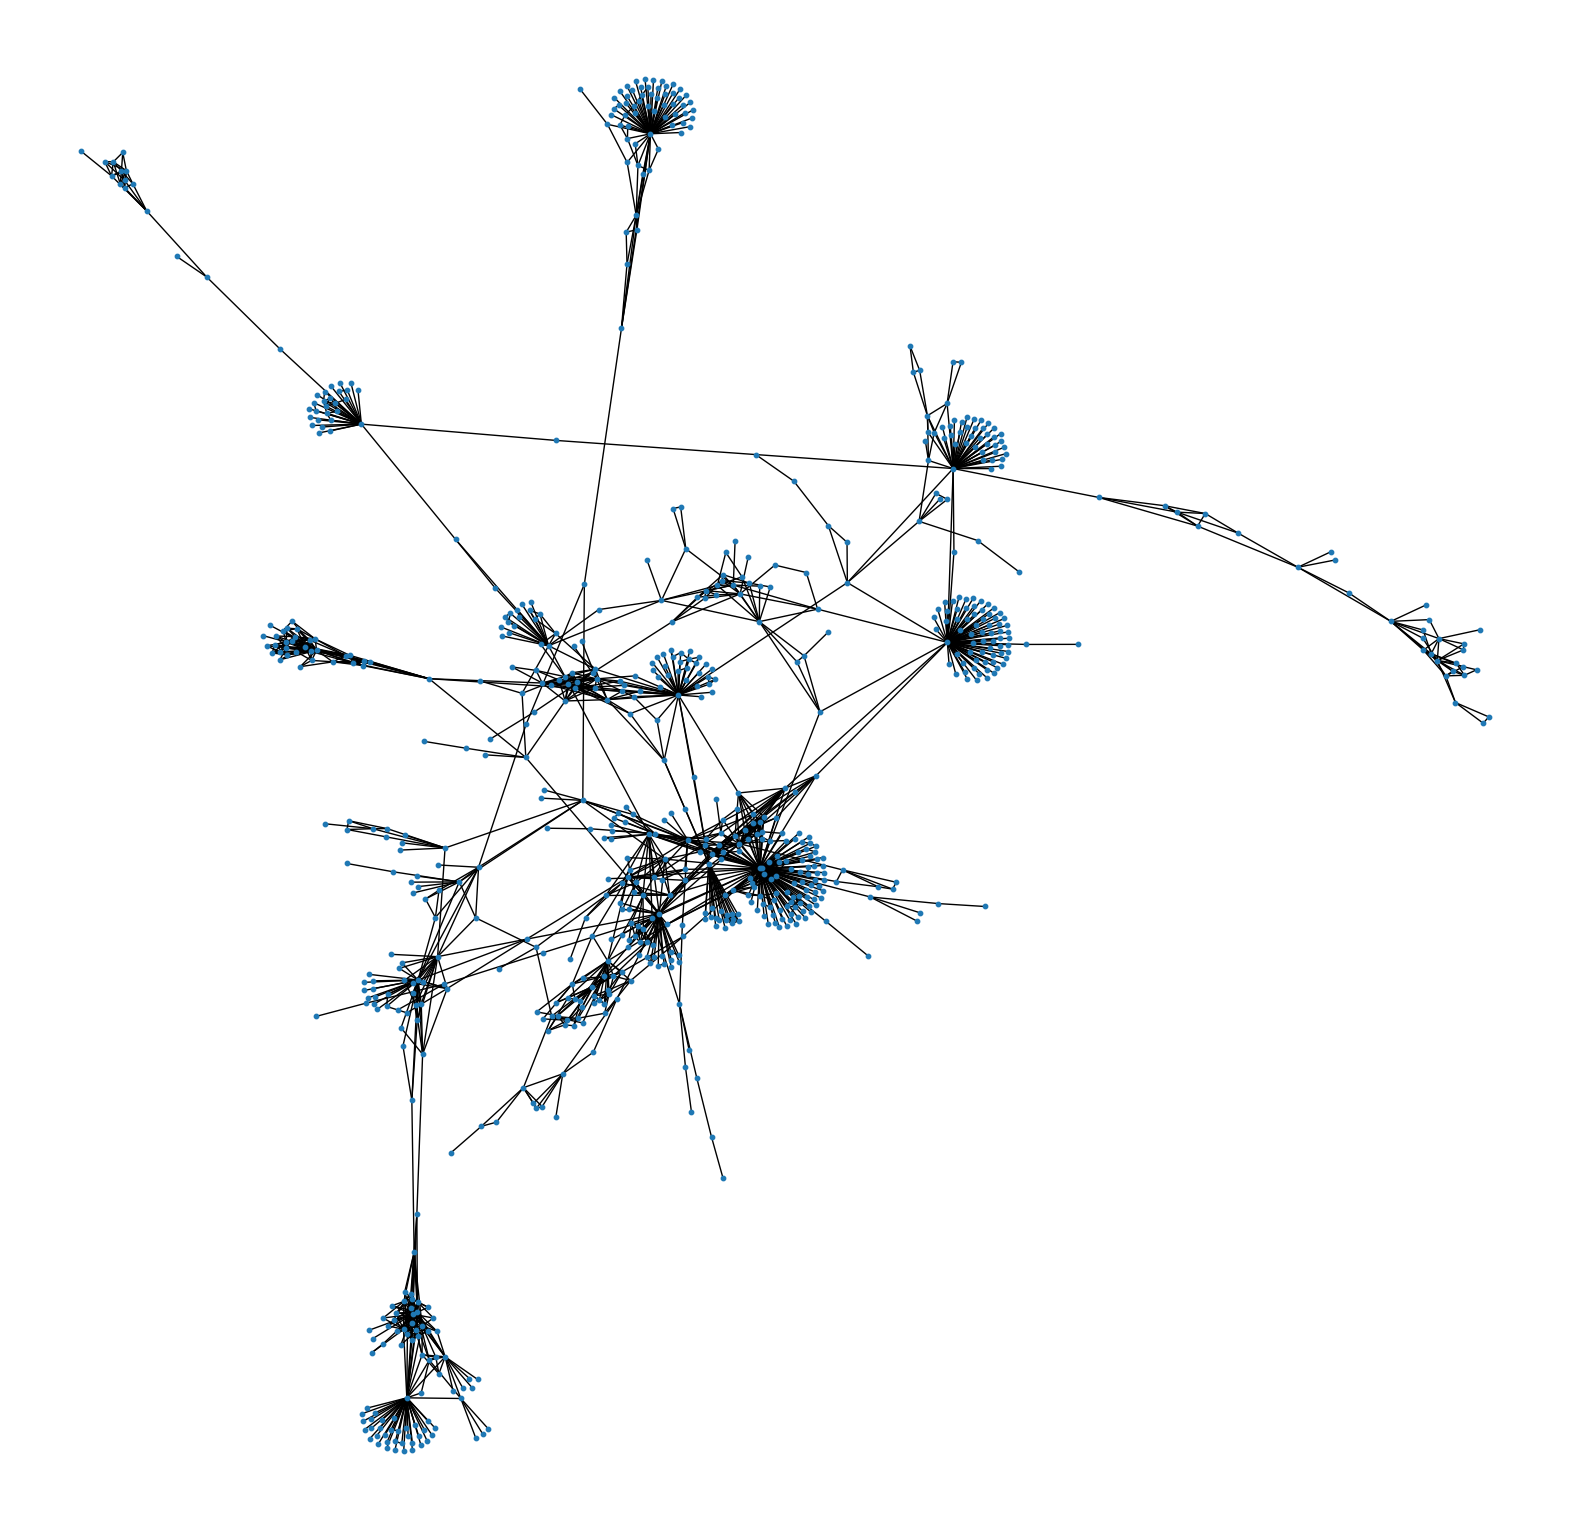

In [9]:
#initialze Figure
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)

# the spectral layout
pos = nx.spring_layout(G, iterations=100)

nx.draw(G,pos, with_labels = False, node_size = 10)
plt.show() #显示出来


Name: 
Type: Graph
Number of nodes: 811
Number of edges: 1597
Average degree:   3.9383
Degree sequence [8, 10, 4, 1, 4, 5, 2, 2, 1, 1, 1, 1, 3, 4, 8, 2, 1, 7, 16, 3, 3, 1, 2, 5, 1, 20, 6, 3, 6, 3, 1, 1, 8, 1, 9, 17, 1, 1, 1, 4, 1, 2, 1, 1, 1, 3, 6, 5, 5, 4, 1, 1, 4, 2, 1, 1, 1, 1, 10, 3, 4, 5, 1, 1, 3, 1, 1, 3, 10, 3, 2, 2, 5, 1, 1, 1, 10, 3, 1, 2, 2, 3, 2, 1, 3, 10, 2, 1, 4, 3, 5, 3, 1, 5, 9, 3, 3, 1, 4, 7, 1, 6, 1, 2, 2, 6, 1, 6, 1, 1, 6, 8, 1, 1, 1, 2, 3, 1, 6, 3, 58, 2, 2, 1, 1, 1, 2, 9, 2, 1, 5, 1, 1, 2, 1, 1, 1, 3, 4, 6, 1, 2, 9, 1, 3, 1, 1, 4, 5, 5, 2, 4, 1, 1, 5, 3, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 3, 1, 3, 5, 5, 8, 2, 3, 5, 1, 1, 3, 1, 5, 2, 3, 1, 2, 1, 2, 9, 1, 1, 1, 1, 3, 1, 1, 1, 6, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 3, 17, 1, 1, 7, 11, 1, 1, 16, 3, 1, 2, 1, 16, 2, 2, 8, 6, 1, 6, 3, 2, 3, 2, 1, 6, 3, 1, 1, 2, 6, 5, 1, 1, 2, 18, 1, 1, 1, 2, 2, 11, 2, 1, 1, 5, 1, 3, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 2, 2, 4, 1, 3, 1, 1, 1, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 22, 1, 4, 9, 11, 3, 4, 8, 2, 4, 4, 

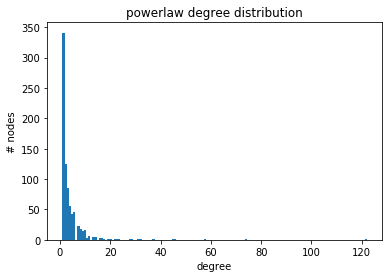

Graph density 0.004862
Diameter (maximum eccentricity): 19
Radius (minimum eccentricity): 10
Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): 13.241676942046857
Center is composed of 3 nodes (nodes with eccentricity equal to radius)
Periphery is composed of 5 nodes (nodes with eccentricity equal to the diameter)
Mean clustering coefficient 0.347288
Total number of triangles in graph: 1217


In [10]:
properties(G)

# Louvain 社区发现，将这些节点划分到不同的社区，根据相似性？

In [9]:
!pip install python-louvain

In [18]:
import community as c
partition = c.best_partition(G)

In [19]:
from collections import defaultdict
comm_dict = defaultdict(list)
for person in partition:
    comm_dict[partition[person]].append(person)

In [ ]:
for i in comm_dict.items():
    print(i)

In [20]:
comm_0 = comm_dict[0]
comm_1 = comm_dict[1]
comm_2 = comm_dict[2]
comm_3 = comm_dict[3]
comm_4 = comm_dict[4]
comm_5 = comm_dict[5]
comm_6 = comm_dict[6]
comm_7 = comm_dict[7]
comm_8 = comm_dict[8]
comm_9 = comm_dict[9]
comm_10 = comm_dict[10]
comm_11 = comm_dict[11]
comm_12 = comm_dict[12]
comm_13 = comm_dict[13]
comm_14 = comm_dict[14]
comm_15 = comm_dict[15]
comm_16 = comm_dict[16]
comm_17 = comm_dict[17]
comm_18 = comm_dict[18]
comm_19 = comm_dict[19]

In [21]:


sub_graph_0 = G.subgraph(comm_0)
sub_graph_1 = G.subgraph(comm_1)
sub_graph_2 = G.subgraph(comm_2)
sub_graph_3 = G.subgraph(comm_3)
sub_graph_4 = G.subgraph(comm_4)
sub_graph_5 = G.subgraph(comm_5)
sub_graph_6 = G.subgraph(comm_6)
sub_graph_7 = G.subgraph(comm_7)
sub_graph_8 = G.subgraph(comm_8)
sub_graph_9 = G.subgraph(comm_9)
sub_graph_10 = G.subgraph(comm_10)
sub_graph_11 = G.subgraph(comm_11)
sub_graph_12 = G.subgraph(comm_12)
sub_graph_13 = G.subgraph(comm_13)
sub_graph_14 = G.subgraph(comm_14)
sub_graph_15 = G.subgraph(comm_15)
sub_graph_16 = G.subgraph(comm_16)
sub_graph_17 = G.subgraph(comm_17)
sub_graph_18 = G.subgraph(comm_18)
sub_graph_19 = G.subgraph(comm_19)

In [22]:
partition_0 = c.best_partition(sub_graph_0)
partition_1 = c.best_partition(sub_graph_1)
partition_2 = c.best_partition(sub_graph_2)
partition_3 = c.best_partition(sub_graph_3)
partition_4 = c.best_partition(sub_graph_4)
partition_5 = c.best_partition(sub_graph_5)
partition_6 = c.best_partition(sub_graph_6)
partition_7 = c.best_partition(sub_graph_7)
partition_8 = c.best_partition(sub_graph_8)
partition_9 = c.best_partition(sub_graph_9)
partition_10 = c.best_partition(sub_graph_10)
partition_11 = c.best_partition(sub_graph_11)
partition_12 = c.best_partition(sub_graph_12)
partition_13 = c.best_partition(sub_graph_13)
partition_14 = c.best_partition(sub_graph_14)
partition_15 = c.best_partition(sub_graph_15)
partition_16 = c.best_partition(sub_graph_16)
partition_17 = c.best_partition(sub_graph_17)
partition_18 = c.best_partition(sub_graph_18)
partition_19 = c.best_partition(sub_graph_19)

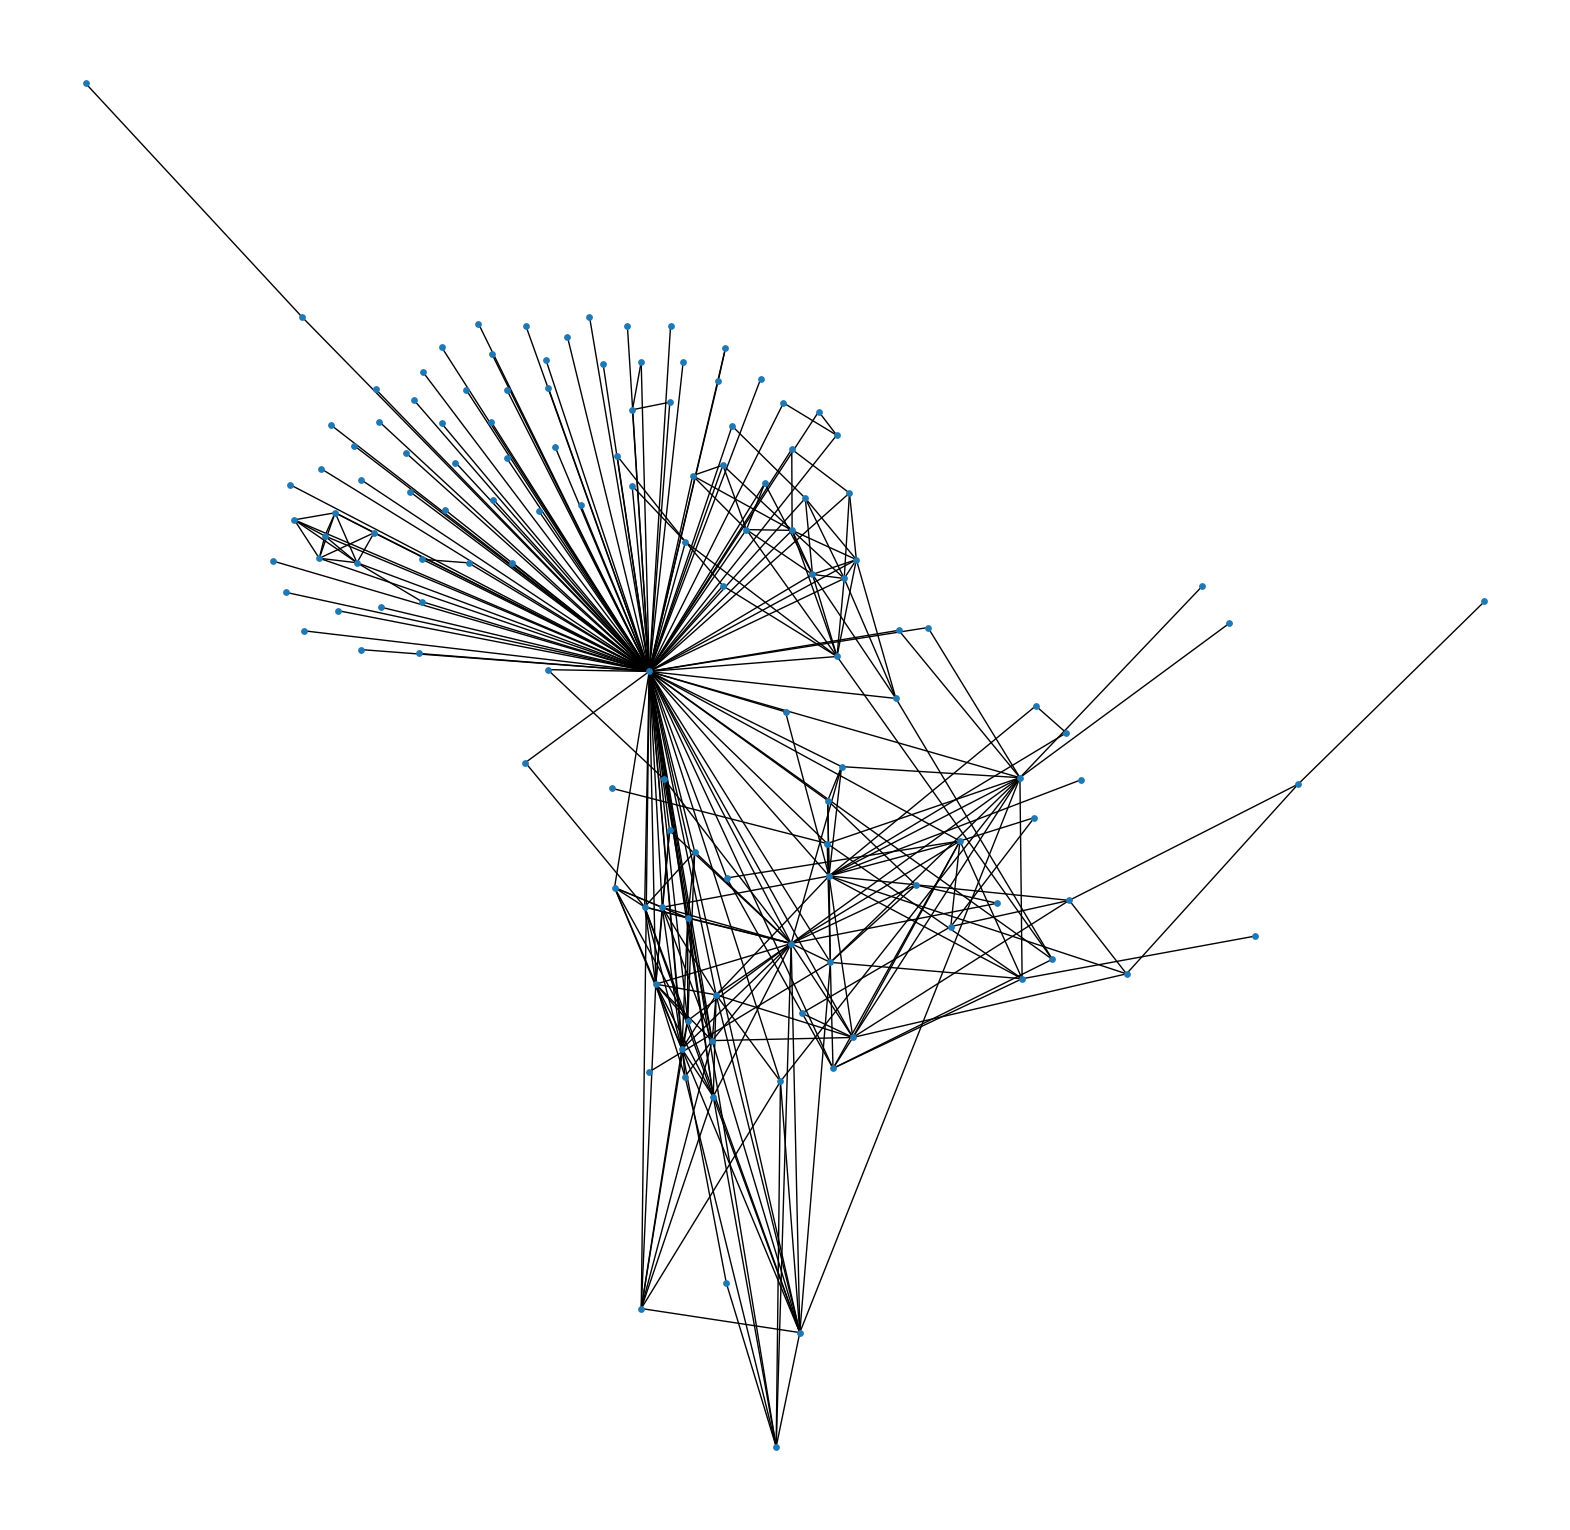

In [23]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G)
sub_graph_0 = G.subgraph(comm_0) 
nx.draw(sub_graph_0,pos, alpha=1,node_size=15)
plt.show()

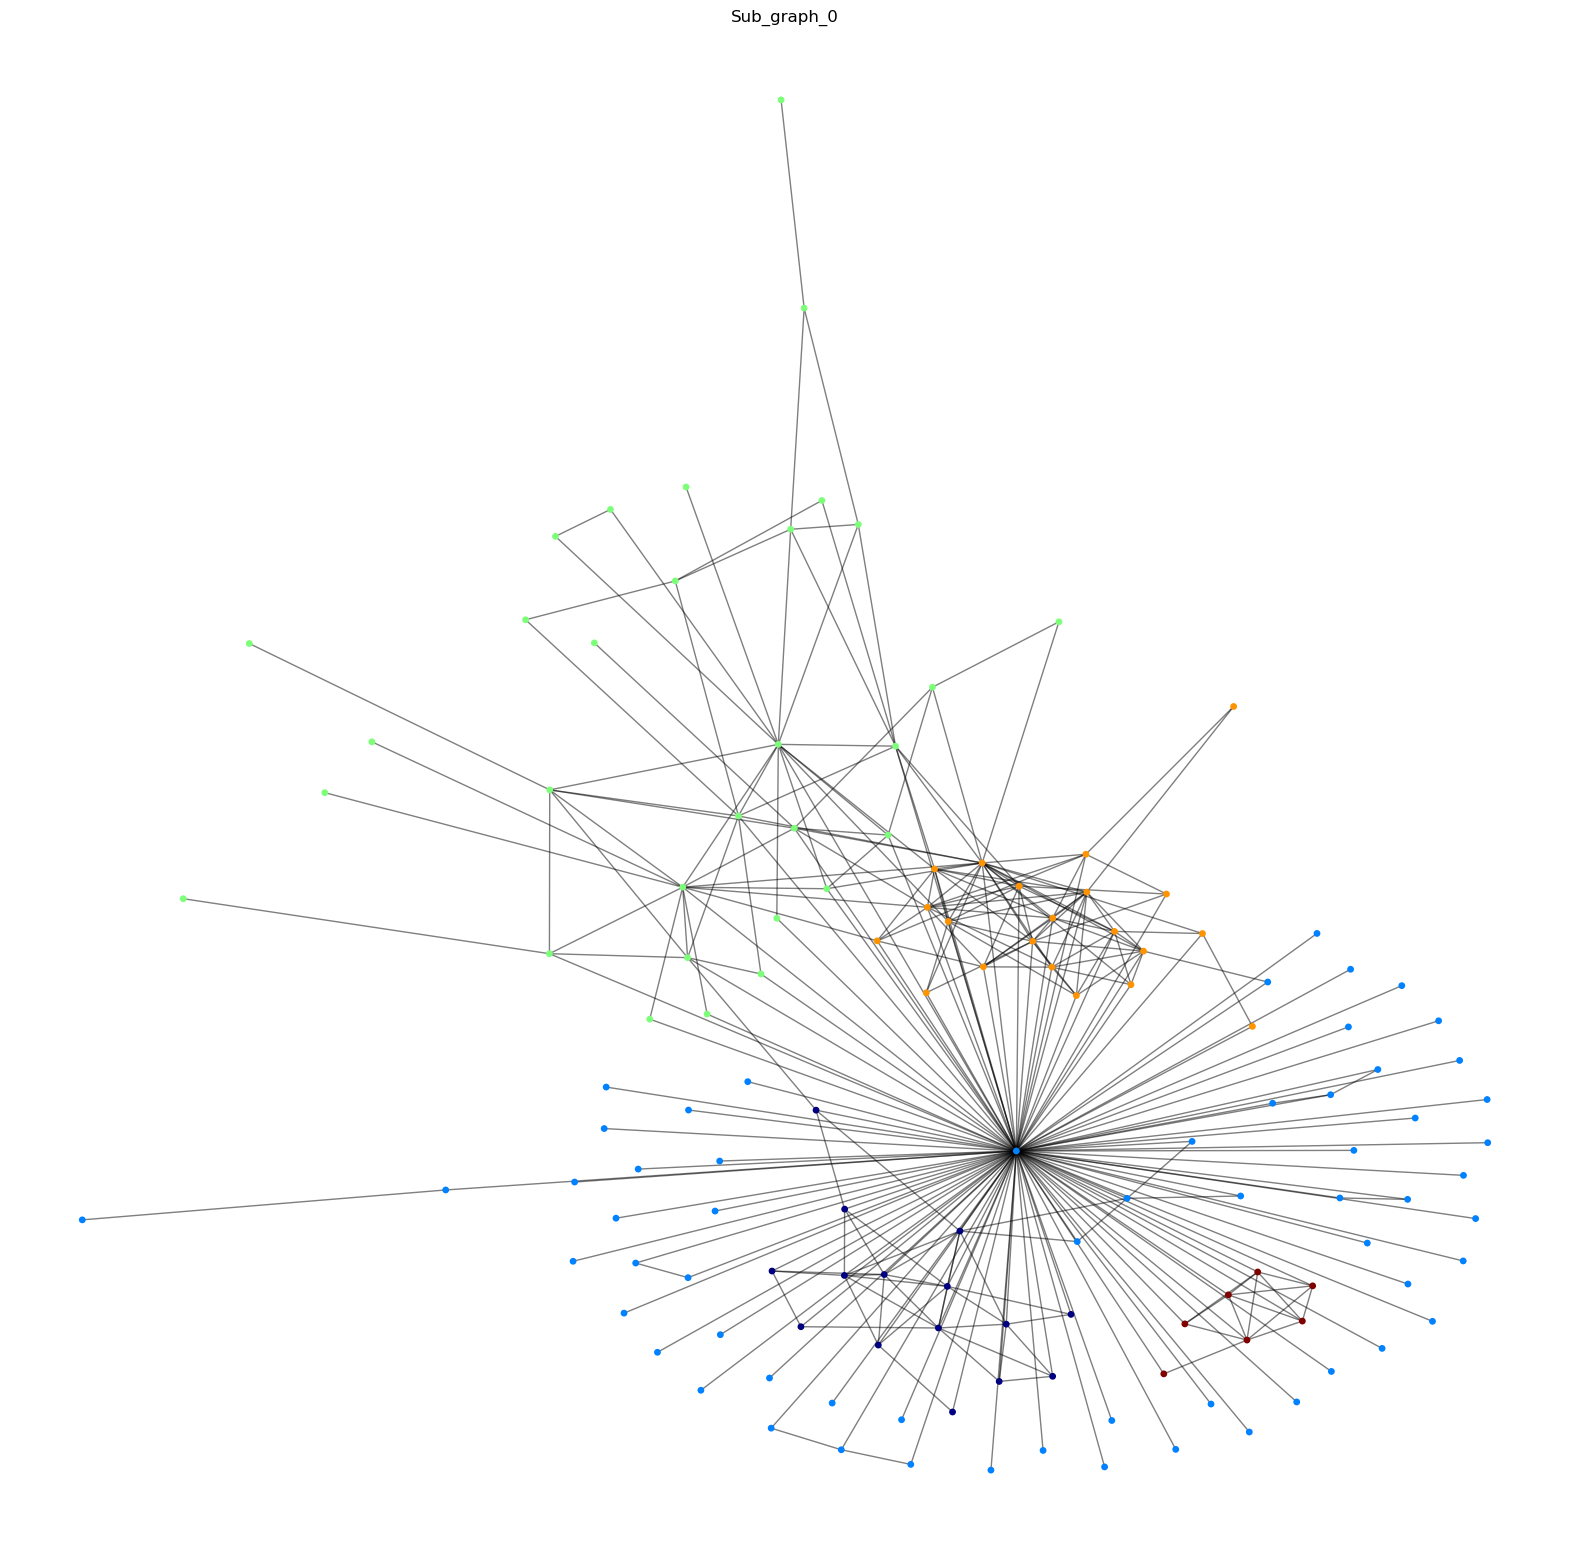

modularity: 0.520407010190664


In [24]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_0.get(node) for node in sub_graph_0.nodes()]
pos=nx.spring_layout(sub_graph_0)
nx.draw_networkx_nodes(sub_graph_0, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_0, pos, alpha=0.5)
plt.title("Sub_graph_0")
plt.show()
mod = c.modularity(partition_0,sub_graph_0)
print("modularity:", mod)

In [ ]:
comm_dict_0 = defaultdict(list)
for person in partition_0:
    comm_dict_0[partition_0[person]].append(person)
print(comm_dict_0)

### 给每一个分区下的小分区使用naive方法进行信息填补

In [82]:
def naive_method_sub_comm(graph, sub_comm_dict, empty, attr):

    comm_empty = []
    for i in sub_comm_dict:
        for j in empty:
            if i == j:
                comm_empty.append(i)
                
    predicted_values={}
    for n in comm_empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
#     print(predicted_values)        
    return predicted_values

### 将每个分区中重新划分的best partition后，各sub_partition的图和人员编号存到字典中

In [94]:
all_people_id = list(G.nodes)
print(len(all_people_id))
all_people_id

811


['U27476',
 'U4665',
 'U1313',
 'U8804',
 'U14078',
 'U9628',
 'U9721',
 'U2649',
 'U27759',
 'U7310',
 'U22859',
 'U1417',
 'U25611',
 'U24095',
 'U3895',
 'U13005',
 'U2620',
 'U5976',
 'U4249',
 'U9140',
 'U16112',
 'U27776',
 'U27708',
 'U15284',
 'U24549',
 'U18514',
 'U15272',
 'U3933',
 'U15946',
 'U25630',
 'U25632',
 'U22031',
 'U11562',
 'U22071',
 'U15292',
 'U7912',
 'U22018',
 'U18925',
 'U7136',
 'U14498',
 'U21990',
 'U3927',
 'U1381',
 'U22087',
 'U27804',
 'U24252',
 'U7355',
 'U12969',
 'U2180',
 'U11815',
 'U4447',
 'U27679',
 'U27582',
 'U27464',
 'U8029',
 'U1075',
 'U24259',
 'U18564',
 'U27283',
 'U11575',
 'U14507',
 'U27477',
 'U25619',
 'U2661',
 'U24143',
 'U8000',
 'U22015',
 'U24152',
 'U11591',
 'U27585',
 'U27498',
 'U9663',
 'U14520',
 'U1441',
 'U2714',
 'U8051',
 'U27300',
 'U9149',
 'U18934',
 'U18948',
 'U4600',
 'U4638',
 'U7379',
 'U7192',
 'U15289',
 'U14005',
 'U24165',
 'U27553',
 'U14015',
 'U15329',
 'U24080',
 'U1073',
 'U18981',
 'U19856',
 

In [90]:
employer_prediction = {}
location_prediction = {}
college_prediction = {}

def graph_comm(graph, comm_dict, partition):
    
    sub_graph = {}
    sub_comm_dict = {}
    sub_partition = {}
    
    sub_employer_pre_dict = {}
    sub_location_pre_dict = {}
    sub_college_pre_dict = {}
    
    comm_dict = defaultdict(list)
    for person in partition:
        comm_dict[partition[person]].append(person)
#     print(comm_dict)
    
    for i in comm_dict.keys():
        sub_comm_dict[i] = comm_dict[i]
        sub_graph[i] = G.subgraph(comm_dict[i])
        sub_partition[i] = c.best_partition(sub_graph[i])
        sub_employer_pre_dict[i] = naive_method_sub_comm(sub_graph[i], sub_comm_dict[i], empty_nodes, employer)
        sub_location_pre_dict[i] = naive_method_sub_comm(sub_graph[i], sub_comm_dict[i], empty_nodes, location)
        sub_college_pre_dict[i] = naive_method_sub_comm(sub_graph[i], sub_comm_dict[i], empty_nodes, college)
        for em_keys, em_values in sub_employer_pre_dict[i].items():
            employer_prediction[em_keys] = em_values
        for loc_keys, loc_values in sub_location_pre_dict[i].items():
            location_prediction[loc_keys] = loc_values
        for co_keys, co_values in sub_college_pre_dict[i].items():
            college_prediction[co_keys] = co_values 

    print("employer_prediction:"+str(employer_prediction))  
    print("location_prediction:"+str(location_prediction))
    print("college_prediction:"+str(college_prediction))
    print("----------------------------------------------------------")
    return employer_prediction, location_prediction, college_prediction

In [91]:
# employer_prediction = {}
# location_prediction = {}
# college_prediction = {}

# def pred_info(graph, comm_dict, partition):
  
    
#     graph_comm(graph, comm_dict, partition)
    
#     print("type:"+type(info[1])
    
#     for em_keys, em_values in sub_employer_pre_dict:
#         employer_prediction[em_keys].append(em_values)
#     for loc_keys, loc_values in sub_location_pre_dict:
#         location_prediction[loc_keys].append(loc_values)
#     for co_keys, co_values in sub_college_pre_dict:
#         college_prediction[co_keys].append(co_values)
        
#     return employer_prediction, location_prediction, college_prediction


### 预测准确率

In [92]:
graph_comm(sub_graph_0, comm_0, partition_0)
graph_comm(sub_graph_1, comm_1, partition_1)
graph_comm(sub_graph_2, comm_2, partition_2)
graph_comm(sub_graph_3, comm_3, partition_3)
graph_comm(sub_graph_4, comm_4, partition_4)
graph_comm(sub_graph_5, comm_5, partition_5)
graph_comm(sub_graph_6, comm_6, partition_6)
graph_comm(sub_graph_7, comm_7, partition_7)
graph_comm(sub_graph_8, comm_8, partition_8)
graph_comm(sub_graph_9, comm_9, partition_9)
graph_comm(sub_graph_10, comm_10, partition_10)
graph_comm(sub_graph_11, comm_11, partition_11)
graph_comm(sub_graph_12, comm_12, partition_12)
graph_comm(sub_graph_13, comm_13, partition_13)
graph_comm(sub_graph_14, comm_14, partition_14)
graph_comm(sub_graph_15, comm_15, partition_15)
graph_comm(sub_graph_16, comm_16, partition_16)
graph_comm(sub_graph_17, comm_17, partition_17)
graph_comm(sub_graph_18, comm_18, partition_18)
graph_comm(sub_graph_19, comm_19, partition_19)

employer_prediction:{'U27516': ['s&amp;p capital iq'], 'U27557': [], 'U25559': [], 'U27499': [], 'U7256': ['university of illinois at urbana-champaign'], 'U24504': ['university of illinois at urbana-champaign'], 'U24045': ['university of illinois at urbana-champaign'], 'U7319': ['university of illinois at urbana-champaign'], 'U27300': ['spot trading llc'], 'U27676': [], 'U25563': ['epic'], 'U27471': ['university of illinois at urbana-champaign'], 'U27508': ['epic'], 'U4665': [], 'U27726': [], 'U27622': [], 'U27748': [], 'U27738': [], 'U27801': [], 'U24549': [], 'U27498': [], 'U27464': [], 'U27708': [], 'U27600': ['university of delaware'], 'U27792': [], 'U27756': [], 'U27287': ['university of delaware'], 'U27698': [], 'U27463': [], 'U24092': [], 'U27663': [], 'U27759': [], 'U27785': [], 'U27604': [], 'U27679': [], 'U27569': [], 'U27649': [], 'U27798': [], 'U26952': [], 'U27737': [], 'U27791': [], 'U27279': [], 'U27711': [], 'U27692': [], 'U27776': [], 'U27635': [], 'U27752': [], 'U2757

employer_prediction:{'U27516': ['s&amp;p capital iq'], 'U27557': [], 'U25559': [], 'U27499': [], 'U7256': ['university of illinois at urbana-champaign'], 'U24504': ['university of illinois at urbana-champaign'], 'U24045': ['university of illinois at urbana-champaign'], 'U7319': ['university of illinois at urbana-champaign'], 'U27300': ['spot trading llc'], 'U27676': [], 'U25563': ['epic'], 'U27471': ['university of illinois at urbana-champaign'], 'U27508': ['epic'], 'U4665': [], 'U27726': [], 'U27622': [], 'U27748': [], 'U27738': [], 'U27801': [], 'U24549': [], 'U27498': [], 'U27464': [], 'U27708': [], 'U27600': ['university of delaware'], 'U27792': [], 'U27756': [], 'U27287': ['university of delaware'], 'U27698': [], 'U27463': [], 'U24092': [], 'U27663': [], 'U27759': [], 'U27785': [], 'U27604': [], 'U27679': [], 'U27569': [], 'U27649': [], 'U27798': [], 'U26952': [], 'U27737': [], 'U27791': [], 'U27279': [], 'U27711': [], 'U27692': [], 'U27776': [], 'U27635': [], 'U27752': [], 'U2757

employer_prediction:{'U27516': ['s&amp;p capital iq'], 'U27557': [], 'U25559': [], 'U27499': [], 'U7256': ['university of illinois at urbana-champaign'], 'U24504': ['university of illinois at urbana-champaign'], 'U24045': ['university of illinois at urbana-champaign'], 'U7319': ['university of illinois at urbana-champaign'], 'U27300': ['spot trading llc'], 'U27676': [], 'U25563': ['epic'], 'U27471': ['university of illinois at urbana-champaign'], 'U27508': ['epic'], 'U4665': [], 'U27726': [], 'U27622': [], 'U27748': [], 'U27738': [], 'U27801': [], 'U24549': [], 'U27498': [], 'U27464': [], 'U27708': [], 'U27600': ['university of delaware'], 'U27792': [], 'U27756': [], 'U27287': ['university of delaware'], 'U27698': [], 'U27463': [], 'U24092': [], 'U27663': [], 'U27759': [], 'U27785': [], 'U27604': [], 'U27679': [], 'U27569': [], 'U27649': [], 'U27798': [], 'U26952': [], 'U27737': [], 'U27791': [], 'U27279': [], 'U27711': [], 'U27692': [], 'U27776': [], 'U27635': [], 'U27752': [], 'U2757

employer_prediction:{'U27516': ['s&amp;p capital iq'], 'U27557': [], 'U25559': [], 'U27499': [], 'U7256': ['university of illinois at urbana-champaign'], 'U24504': ['university of illinois at urbana-champaign'], 'U24045': ['university of illinois at urbana-champaign'], 'U7319': ['university of illinois at urbana-champaign'], 'U27300': ['spot trading llc'], 'U27676': [], 'U25563': ['epic'], 'U27471': ['university of illinois at urbana-champaign'], 'U27508': ['epic'], 'U4665': [], 'U27726': [], 'U27622': [], 'U27748': [], 'U27738': [], 'U27801': [], 'U24549': [], 'U27498': [], 'U27464': [], 'U27708': [], 'U27600': ['university of delaware'], 'U27792': [], 'U27756': [], 'U27287': ['university of delaware'], 'U27698': [], 'U27463': [], 'U24092': [], 'U27663': [], 'U27759': [], 'U27785': [], 'U27604': [], 'U27679': [], 'U27569': [], 'U27649': [], 'U27798': [], 'U26952': [], 'U27737': [], 'U27791': [], 'U27279': [], 'U27711': [], 'U27692': [], 'U27776': [], 'U27635': [], 'U27752': [], 'U2757

({'U27516': ['s&amp;p capital iq'],
  'U27557': [],
  'U25559': [],
  'U27499': [],
  'U7256': ['university of illinois at urbana-champaign'],
  'U24504': ['university of illinois at urbana-champaign'],
  'U24045': ['university of illinois at urbana-champaign'],
  'U7319': ['university of illinois at urbana-champaign'],
  'U27300': ['spot trading llc'],
  'U27676': [],
  'U25563': ['epic'],
  'U27471': ['university of illinois at urbana-champaign'],
  'U27508': ['epic'],
  'U4665': [],
  'U27726': [],
  'U27622': [],
  'U27748': [],
  'U27738': [],
  'U27801': [],
  'U24549': [],
  'U27498': [],
  'U27464': [],
  'U27708': [],
  'U27600': ['university of delaware'],
  'U27792': [],
  'U27756': [],
  'U27287': ['university of delaware'],
  'U27698': [],
  'U27463': [],
  'U24092': [],
  'U27663': [],
  'U27759': [],
  'U27785': [],
  'U27604': [],
  'U27679': [],
  'U27569': [],
  'U27649': [],
  'U27798': [],
  'U26952': [],
  'U27737': [],
  'U27791': [],
  'U27279': [],
  'U27711': [

In [93]:
result_employer=evaluation_accuracy(groundtruth_employer,employer_prediction)
print("%f%% of the predictions are true" % result_employer)

result_location=evaluation_accuracy(groundtruth_location,location_prediction)
print("%f%% of the predictions are true" % result_location)

result_college=evaluation_accuracy(groundtruth_college,college_prediction)
print("%f%% of the predictions are true" % result_college)

print("Very poor result!!! Try to do better!!!!")

18.487395% of the predictions are true
33.064516% of the predictions are true
28.318584% of the predictions are true
Very poor result!!! Try to do better!!!!


### 设想：
* 将全图进行详尽的分区，然后使用观察邻居信息的方式，选取最高频率信息进行预测填补。

### 方式：
* 两次louvain分区 + naive method预测。

### 结论：
* employer、college预测正确率相比全图直接使用naive method下降约0.5%，location预测正确率上升约1%。效果很不好。

### 原因分析：
* 1. 缺失数据过多，导致两次分区后，许多区连一个信息都没有，直接导致未能成功将信息填补，在验证正确率过程中还有小部分信息未填全
* 2. 划分过细，导致分区后小区内数据过于单一，直接导致整个小区被填写了同样的数据。未达到有效的预测。

### 下一步：
* 将两次louvain分区降为一次，然后进行naive method预测。

In [98]:
comm = {}
sub_graph = {}
# partition = {}

for c_keys, c_values in comm_dict.items():
    comm[c_keys] = c_values
    sub_graph[c_keys] = G.subgraph(c_values)

# for g_keys, g_values in sub_graph.items():
#     partition[g_keys] = c.best_partition(g_values)

In [101]:
pre_value_sub_emp = {}
pre_value_sub_loc = {}
pre_value_sub_co = {}

emp_pre = {}
loc_pre = {}
co_pre = {}


for i in range(0,20):
    pre_value_sub_emp[i] = naive_method_sub_comm(sub_graph[i], comm[i], empty_nodes, employer)
    pre_value_sub_loc[i] = naive_method_sub_comm(sub_graph[i], comm[i], empty_nodes, location)
    pre_value_sub_co[i] = naive_method_sub_comm(sub_graph[i], comm[i], empty_nodes, college)
    for em_keys, em_values in pre_value_sub_emp[i].items():
        emp_pre[em_keys] = em_values
    for loc_keys, loc_values in pre_value_sub_loc[i].items():
        loc_pre[loc_keys] = loc_values
    for co_keys, co_values in pre_value_sub_co[i].items():
        co_pre[co_keys] = co_values 

In [102]:
result_employer=evaluation_accuracy(groundtruth_employer,emp_pre)
print("%f%% of the predictions are true" % result_employer)

result_location=evaluation_accuracy(groundtruth_location,loc_pre)
print("%f%% of the predictions are true" % result_location)

result_college=evaluation_accuracy(groundtruth_college,co_pre)
print("%f%% of the predictions are true" % result_college)

print("Very poor result!!! Try to do better!!!!")

19.767442% of the predictions are true
32.330827% of the predictions are true
30.000000% of the predictions are true
Very poor result!!! Try to do better!!!!


In [103]:
print(str(loc_pre))

{'U27476': ['san francisco bay area'], 'U4665': [], 'U27759': [], 'U27776': [], 'U27708': [], 'U24549': [], 'U27804': [], 'U27679': [], 'U27464': [], 'U27477': ['greater san diego area'], 'U27498': [], 'U27300': ['urbana-champaign illinois area'], 'U27553': [], 'U27460': ['san francisco bay area'], 'U27711': [], 'U27752': [], 'U27657': ['austin texas area'], 'U27676': [], 'U24077': ['urbana-champaign illinois area'], 'U27463': [], 'U27588': ['san francisco bay area'], 'U27604': [], 'U27756': [], 'U16134': ['greater nashville area'], 'U27748': [], 'U27577': [], 'U2696': [], 'U27499': ['urbana-champaign illinois area'], 'U2656': ['urbana-champaign illinois area'], 'U27473': ['greater san diego area'], 'U27687': [], 'U27279': [], 'U26952': [], 'U16115': ['greater nashville area'], 'U27634': ['greater san diego area'], 'U27779': [], 'U27649': [], 'U27785': [], 'U27471': ['urbana-champaign illinois area'], 'U27746': [], 'U27726': [], 'U27792': [], 'U28776': ['san francisco bay area'], 'U262

# 获得基本一样的结果！！！！！疯了！！！！！！

* 设想3：
* louvain
* 图中节点
* 遍历点 找每个点的三角关系（找一个点的邻居，遍历邻居和邻居，是否有联系，有联系则为三角，然后共享信息）
* 遍历整张图 找没有信息的点 如果没有信息 则找周围邻居最大frequence的信息将其填补

In [25]:
comm = {}
sub_graph = {}
# partition = {}

for c_keys, c_values in comm_dict.items():
    comm[c_keys] = c_values
    sub_graph[c_keys] = G.subgraph(c_values)

In [222]:
college={}
location={}
employer={}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)

In [225]:
employer

{'U1313': ['discovery education',
  'ctb mcgraw-hill',
  'university of charleston university of south carolina',
  'south carolina department of education',
  'chesapeake va and sumter sc',
  'virgina state corrections'],
 'U8804': ['gruppo euris spa',
  'iconsulting',
  'econoetica',
  'universit&#xe0; di bologna',
  'university of illinois at urbana-champaign'],
 'U2649': ['bocom international',
  'inventiv health',
  'glaxosmithkline plc',
  'zhongrong international trust co. ltd'],
 'U7310': ['microsoft',
  'illinois computer technology',
  'university of illinois at urbana-champaign',
  'state farm insurance'],
 'U22859': ['amazon',
  'ibm india research lab',
  'coordinated science lab',
  'toyota technical center'],
 'U1417': ['designing events'],
 'U25611': ['bluegranite', 'measured progress', 'sweetser'],
 'U3895': ['vertica systems an hp company',
  'morgan stanley',
  'microsoft',
  'google'],
 'U13005': ['illinois state university',
  'university of illinois at urbana-cham

In [226]:
location

{'U1313': ['norfolk virginia area'],
 'U8804': ['bologna area italy'],
 'U2649': ['urbana-champaign illinois area'],
 'U7310': ['greater seattle area'],
 'U22859': ['bengaluru area india'],
 'U1417': ['baltimore maryland area'],
 'U25611': ['greater boston area'],
 'U3895': ['greater boston area'],
 'U13005': ['bloomington normal illinois area'],
 'U2620': ['urbana-champaign illinois area'],
 'U5976': ['urbana-champaign illinois area'],
 'U9140': ['urbana-champaign illinois area'],
 'U16112': ['china'],
 'U15272': ['san francisco bay area'],
 'U3933': ['shanghai city china'],
 'U11562': ['urbana-champaign illinois area'],
 'U22071': ['greater chicago area'],
 'U15292': ['urbana-champaign illinois area'],
 'U14498': ['madison wisconsin area'],
 'U21990': ['greater chicago area'],
 'U24252': ['washington d.c. metro area'],
 'U12969': ['greater chicago area'],
 'U2180': ['urbana-champaign illinois area'],
 'U4447': ['greater minneapolis-st. paul area'],
 'U27582': ['urbana-champaign illin

In [223]:
#######################################
emp_pre_tri = {}
loc_pre_tri = {}
co_pre_tri = {}

for i in groundtruth_employer.keys():
    if len(list(groundtruth_employer[i]))==1 :
        print(i, groundtruth_employer[i])
        emp_pre_tri[i]= [groundtruth_employer[i][0]]
        print(i,emp_pre_tri[i])
        print("-------------------------------------")
for j in groundtruth_location.keys():
    if len(list(groundtruth_location[j]))==1:
        loc_pre_tri[j]= [groundtruth_location[j][0]]
for k in groundtruth_college.keys():
    if len(list(groundtruth_college[k]))==1:
        co_pre_tri[k]= [groundtruth_college[k][0]]


U14078 ['kth']
U14078 ['kth']
-------------------------------------
U9721 ['caterpillar inc.']
U9721 ['caterpillar inc.']
-------------------------------------
U6021 ['sony biotechnology inc.']
U6021 ['sony biotechnology inc.']
-------------------------------------
U27759 ['university of illinois at urbana-champaign']
U27759 ['university of illinois at urbana-champaign']
-------------------------------------
U1417 ['designing events']
U1417 ['designing events']
-------------------------------------
U16112 ['pwc']
U16112 ['pwc']
-------------------------------------
U25632 ['john deere']
U25632 ['john deere']
-------------------------------------
U3927 ['morgan stanley']
U3927 ['morgan stanley']
-------------------------------------
U27804 ['ibm']
U27804 ['ibm']
-------------------------------------
U14024 ['university of illinois at urbana-champaign']
U14024 ['university of illinois at urbana-champaign']
-------------------------------------
U8029 ['presque isle county sheriff departme

In [186]:
emp_pre_tri

{'U14078': 'kth',
 'U9721': 'caterpillar inc.',
 'U6021': 'sony biotechnology inc.',
 'U27759': 'university of illinois at urbana-champaign',
 'U1417': 'designing events',
 'U16112': 'pwc',
 'U25632': 'john deere',
 'U3927': 'morgan stanley',
 'U27804': 'ibm',
 'U14024': 'university of illinois at urbana-champaign',
 'U8029': 'presque isle county sheriff department',
 'U24259': 'amazon',
 'U18564': 'microsoft',
 'U14507': 'university of illinois urbana-champaign',
 'U27477': 'university of washington',
 'U8000': 'aerofoams industries inc',
 'U24152': 'university of turku',
 'U8051': 'mcfadden lighting',
 'U18934': 'benjamin an and co. p.c.',
 'U18948': 'cummins inc.',
 'U14005': 'university of miami',
 'U1108': 'university of texas at austin',
 'U14015': 'open systems laboratory university of illinois at urbana-champaign',
 'U1073': 'educational testing service (ets)',
 'U18981': 'university of illinois at urbana-champaign',
 'U3958': 'microsoft',
 'U2625': 'microsoft',
 'U14575': 'car

In [187]:
len(emp_pre_tri)

234

In [188]:
len(loc_pre_tri)

811

In [189]:
groundtruth_location

{'U27476': ['greater new york city area'],
 'U4665': ['greater chicago area'],
 'U1313': ['norfolk virginia area'],
 'U8804': ['bologna area italy'],
 'U14078': ['stockholm sweden'],
 'U9628': ['greater los angeles area'],
 'U9721': ['urbana-champaign illinois area'],
 'U6021': ['urbana-champaign illinois area'],
 'U27759': ['urbana-champaign illinois area'],
 'U7310': ['greater seattle area'],
 'U22859': ['bengaluru area india'],
 'U1417': ['baltimore maryland area'],
 'U25611': ['greater boston area'],
 'U24095': ['greater chicago area'],
 'U3895': ['greater boston area'],
 'U13005': ['bloomington normal illinois area'],
 'U2620': ['urbana-champaign illinois area'],
 'U4249': ['urbana-champaign illinois area'],
 'U9140': ['urbana-champaign illinois area'],
 'U16112': ['china'],
 'U9724': ['urbana-champaign illinois area'],
 'U27708': ['beijing city china'],
 'U18954': ['greater chicago area'],
 'U24549': ['san francisco bay area'],
 'U18514': ['urbana-champaign illinois area'],
 'U15

In [194]:
groundtruth_employer

{'U21998': ['illinois college advising corps',
  'victoria amplifiers',
  'university of illinois at chicago'],
 'U27476': ['ibm',
  'nyse euronext',
  'skim.me',
  'shanghai pudong development bank',
  'qad'],
 'U4665': ['technology services group - chicago', 'ge healthcare'],
 'U1313': ['discovery education',
  'ctb mcgraw-hill',
  'university of charleston university of south carolina',
  'south carolina department of education',
  'chesapeake va and sumter sc',
  'virgina state corrections'],
 'U8804': ['gruppo euris spa',
  'iconsulting',
  'econoetica',
  'universit&#xe0; di bologna',
  'university of illinois at urbana-champaign'],
 'U14078': ['kth'],
 'U9628': ['sc johnson',
  'university of illinois at urbana-champaign',
  'palos verdes beach &amp; athletic club'],
 'U9721': ['caterpillar inc.'],
 'U6021': ['sony biotechnology inc.'],
 'U27759': ['university of illinois at urbana-champaign'],
 'U7310': ['microsoft',
  'illinois computer technology',
  'university of illinois a

In [198]:
groundtruth_college

{'U22041': ['university of illinois at urbana-champaign'],
 'U27476': ['shanghai jiao tong university'],
 'U4665': ['university of illinois at urbana-champaign'],
 'U1313': ['longwood university'],
 'U8804': ['universit&#xe0; di bologna'],
 'U15946': ['indian institute of technology bombay'],
 'U2136': ['university of illinois at urbana-champaign'],
 'U9721': ['university of illinois at urbana-champaign'],
 'U1380': ['georgetown university'],
 'U2649': ['shanghai university of finance and economics'],
 'U27759': ['southeast university'],
 'U7310': ['university of illinois at urbana-champaign'],
 'U22859': ['indian institute of technology madras'],
 'U2108': ['university of illinois at urbana-champaign'],
 'U11575': ['shanghai jiao tong university'],
 'U25611': ['university of southern maine', 'penn high school'],
 'U24095': ['dalian university of technology'],
 'U2631': ['beihang university'],
 'U3895': ['shanghai jiao tong university'],
 'U13005': ['university of illinois at urbana-ch

In [195]:
len(groundtruth_employer)

730

In [196]:
len(groundtruth_location)

811

In [197]:
len(groundtruth_college)

540

In [182]:
groundtruth_employer['U27287'][0]

'university of illinois at urbana-champaign'

In [228]:


def pred_tri(graph, comm, empty, attr):
    
    predicted_values = {}
    
    comm_empty = [] #需要填补信息的点列表
    for i in comm:
        for j in empty:
            if i == j:
                comm_empty.append(i)
                
    n_nbr_1 = {} 
    nbrs_attr_values = []
    
    #查看每个点的邻居都有谁
    for node in comm_empty:
        n_nbr_1[node] = list(graph.neighbors(node))
    
    ordered_n_nbr_1 = OrderedDict(sorted(n_nbr_1.items(), key=lambda x: len(x[1])))
#     print(n_nbr_1)
    print(ordered_n_nbr_1)
    
    for node, nbrs in ordered_n_nbr_1.items():#遍历需要填补的点和其邻居
        predicted_values[node] = []
        nbrs_attr_values=[]
        for n in nbrs:#遍历该点的邻居
            print("node")
            print(node)
            set_share_nbr = set(nbrs) & set(graph.neighbors(n))#检查需要填补的点和其邻居间有没有共同的邻居
            list_share_nbr = list(set_share_nbr)#将两个点共同的邻居存入列表
            if list_share_nbr:#如果列表不为空
                print("Yes, Triangle: ")
                print(len(list_share_nbr))
                print(list_share_nbr)
                
                for nbr_attr in list_share_nbr:#则遍历该表中的点
                    if nbr_attr in attr.keys():
#                         print(nbr_attr)
                        for val in attr[nbr_attr]:#获取点的属性值
#                             print(val)
                            if not val in predicted_values[node]:
#                                 print("already exist")
#                             else:
                                predicted_values[node].append(val)#并将属性值加入列表
#             print(predicted_values[node])
#             print("------------------------------------")
#         predicted_values[node].append(set(nbrs_attr_values))#给需填补点添加属性信息
#     print(predicted_values)
        
    return predicted_values
                
        

In [179]:
print(groundtruth_employer['U27287'])
print(groundtruth_location['U27287'])
print(groundtruth_college['U27287'])
      

['university of illinois at urbana-champaign']
['urbana-champaign illinois area']
['university of illinois at urbana-champaign', 'shanghai jiao tong university', 'university of new mexico', 'hong kong university of science and technology']


In [229]:


pre_value_sub_emp_tri = {}
pre_value_sub_loc_tri = {}
pre_value_sub_co_tri = {}




for i in range(0,20):
    pre_value_sub_emp_tri[i] = pred_tri(sub_graph[i], comm[i], empty_nodes, employer)
    pre_value_sub_loc_tri[i] = pred_tri(sub_graph[i], comm[i], empty_nodes, location)
    pre_value_sub_co_tri[i] = pred_tri(sub_graph[i], comm[i], empty_nodes, college)
    
    
for j in range(0,20): 

    for emp in pre_value_sub_emp_tri[j].keys():
#         print(emp)
        emp_pre_tri[emp] =  pre_value_sub_emp_tri[j][emp]
    for loc in pre_value_sub_loc_tri[j].keys():
        loc_pre_tri[loc] = pre_value_sub_loc_tri[j][loc]
    for co in pre_value_sub_co_tri[j].keys():
        co_pre_tri[co] = pre_value_sub_co_tri[j][co]

OrderedDict([('U27759', ['U27287']), ('U27776', ['U27287']), ('U24549', ['U27287']), ('U27804', ['U27287']), ('U27679', ['U27287']), ('U27553', ['U27287']), ('U27711', ['U27287']), ('U27752', ['U27287']), ('U11590', ['U11559']), ('U27604', ['U27287']), ('U27756', ['U27287']), ('U27748', ['U27287']), ('U27577', ['U27287']), ('U2696', ['U2656']), ('U27279', ['U27287']), ('U26952', ['U27287']), ('U27779', ['U27287']), ('U27649', ['U27287']), ('U27785', ['U27287']), ('U27746', ['U27287']), ('U27726', ['U27287']), ('U27792', ['U27287']), ('U27698', ['U27287']), ('U27801', ['U27287']), ('U24092', ['U27287']), ('U2724', ['U2656']), ('U27663', ['U27287']), ('U27692', ['U27287']), ('U28774', ['U11566']), ('U27622', ['U27287']), ('U16179', ['U16134']), ('U27791', ['U27287']), ('U27635', ['U27287']), ('U27738', ['U27287']), ('U27674', ['U27287']), ('U27737', ['U27287']), ('U27798', ['U27287']), ('U27708', ['U27287', 'U27569']), ('U27464', ['U27463', 'U27287']), ('U27498', ['U27463', 'U27287']), (

node
U27801
node
U24092
node
U2724
node
U27663
node
U27692
node
U28774
node
U27622
node
U16179
node
U27791
node
U27635
node
U27738
node
U27674
node
U27737
node
U27798
node
U27708
Yes, Triangle: 
1
['U27569']
node
U27708
Yes, Triangle: 
1
['U27287']
node
U27464
Yes, Triangle: 
1
['U27287']
node
U27464
Yes, Triangle: 
1
['U27463']
node
U27498
Yes, Triangle: 
1
['U27287']
node
U27498
Yes, Triangle: 
1
['U27463']
node
U27657
Yes, Triangle: 
1
['U27475']
node
U27657
Yes, Triangle: 
1
['U27287']
node
U24077
Yes, Triangle: 
1
['U24045']
node
U24077
Yes, Triangle: 
1
['U24046']
node
U27687
Yes, Triangle: 
1
['U27575']
node
U27687
Yes, Triangle: 
1
['U27287']
node
U16177
node
U16177
node
U28776
Yes, Triangle: 
1
['U28772']
node
U28776
Yes, Triangle: 
1
['U11566']
node
U25559
node
U25559
node
U27600
Yes, Triangle: 
1
['U27287']
node
U27600
Yes, Triangle: 
1
['U27636']
node
U16174
Yes, Triangle: 
1
['U16078']
node
U16174
Yes, Triangle: 
1
['U4586']
node
U27569
Yes, Triangle: 
1
['U27287']
node
U2

Yes, Triangle: 
2
['U16127', 'U27287']
node
U24045
Yes, Triangle: 
7
['U27499', 'U27287', 'U27471', 'U27289', 'U27300', 'U25563', 'U27283']
node
U27287
Yes, Triangle: 
7
['U27634', 'U27661', 'U27477', 'U27515', 'U27541', 'U27525', 'U27532']
node
U27287
Yes, Triangle: 
8
['U24045', 'U27516', 'U27676', 'U27471', 'U25563', 'U11566', 'U27557', 'U24504']
node
U27287
node
U27287
node
U27287
node
U27287
Yes, Triangle: 
1
['U27569']
node
U27287
node
U27287
node
U27287
node
U27287
Yes, Triangle: 
3
['U27471', 'U7256', 'U27516']
node
U27287
Yes, Triangle: 
1
['U27463']
node
U27287
Yes, Triangle: 
9
['U24045', 'U7256', 'U7319', 'U27508', 'U24184', 'U27471', 'U27289', 'U25563', 'U24504']
node
U27287
Yes, Triangle: 
4
['U11597', 'U27515', 'U27541', 'U27476']
node
U27287
Yes, Triangle: 
2
['U27661', 'U27575']
node
U27287
Yes, Triangle: 
1
['U27463']
node
U27287
Yes, Triangle: 
9
['U24045', 'U27499', 'U27508', 'U24184', 'U27471', 'U27289', 'U25563', 'U27557', 'U7319']
node
U27287
node
U27287
Yes, Tri

6
['U24045', 'U27287', 'U24184', 'U27283', 'U27300', 'U24504']
node
U7319
Yes, Triangle: 
4
['U24045', 'U27287', 'U27507', 'U27283']
node
U27471
Yes, Triangle: 
7
['U24045', 'U27287', 'U27516', 'U25563', 'U27676', 'U27557', 'U24504']
node
U27471
Yes, Triangle: 
2
['U27287', 'U27516']
node
U27471
Yes, Triangle: 
6
['U24045', 'U27287', 'U27508', 'U24184', 'U25563', 'U24504']
node
U27471
Yes, Triangle: 
6
['U24045', 'U27287', 'U27508', 'U24184', 'U25563', 'U27557']
node
U27471
Yes, Triangle: 
3
['U4665', 'U27287', 'U24045']
node
U27471
Yes, Triangle: 
5
['U27287', 'U27516', 'U27300', 'U25563', 'U27283']
node
U27471
Yes, Triangle: 
9
['U4665', 'U24045', 'U27287', 'U27508', 'U24184', 'U27283', 'U27300', 'U27557', 'U24504']
node
U27471
Yes, Triangle: 
12
['U4665', 'U24045', 'U27582', 'U27516', 'U24184', 'U27508', 'U27283', 'U27300', 'U25563', 'U27676', 'U27557', 'U24504']
node
U27471
Yes, Triangle: 
6
['U4665', 'U24045', 'U27582', 'U27287', 'U24184', 'U24504']
node
U27471
Yes, Triangle: 
5
[

['U13969']
node
U8670
node
U8670
Yes, Triangle: 
3
['U13995', 'U24143', 'U8795']
node
U8670
Yes, Triangle: 
2
['U13969', 'U8795']
node
U8670
Yes, Triangle: 
2
['U24177', 'U24139']
node
U8670
Yes, Triangle: 
1
['U24130']
node
U8670
Yes, Triangle: 
3
['U8741', 'U24143', 'U8795']
node
U8670
Yes, Triangle: 
7
['U11587', 'U8710', 'U13961', 'U13968', 'U13969', 'U24154', 'U8795']
node
U8670
Yes, Triangle: 
8
['U24165', 'U8741', 'U13961', 'U8699', 'U13995', 'U13968', 'U24154', 'U8795']
node
U8670
Yes, Triangle: 
2
['U13969', 'U13995']
node
U8670
Yes, Triangle: 
1
['U13995']
node
U8670
node
U8670
node
U8670
Yes, Triangle: 
3
['U13969', 'U13995', 'U8795']
node
U8670
Yes, Triangle: 
2
['U24252', 'U24205']
node
U8670
node
U8670
Yes, Triangle: 
1
['U24139']
node
U8670
Yes, Triangle: 
5
['U24218', 'U24241', 'U24252', 'U24128', 'U24177']
node
U8670
Yes, Triangle: 
1
['U8795']
node
U8670
node
U8670
Yes, Triangle: 
2
['U24183', 'U24139']
node
U8670
node
U8670
Yes, Triangle: 
2
['U24152', 'U24158']
node

node
U15193
node
U14138
node
U9694
node
U19873
node
U9721
node
U9721
node
U9663
node
U9663
node
U15173
Yes, Triangle: 
1
['U15174']
node
U15173
Yes, Triangle: 
1
['U15177']
node
U9706
node
U9706
node
U14109
Yes, Triangle: 
1
['U14136']
node
U14109
Yes, Triangle: 
1
['U14068']
node
U15174
Yes, Triangle: 
1
['U15177']
node
U15174
Yes, Triangle: 
1
['U15173']
node
U9649
Yes, Triangle: 
1
['U9710']
node
U9649
Yes, Triangle: 
1
['U9630']
node
U14124
Yes, Triangle: 
1
['U14123']
node
U14124
Yes, Triangle: 
1
['U14068']
node
U14072
Yes, Triangle: 
1
['U14068']
node
U14072
Yes, Triangle: 
1
['U14080']
node
U9724
Yes, Triangle: 
1
['U9711']
node
U9724
Yes, Triangle: 
1
['U9710']
node
U15190
Yes, Triangle: 
1
['U15197']
node
U15190
Yes, Triangle: 
1
['U15168']
node
U14121
Yes, Triangle: 
1
['U14068']
node
U14121
Yes, Triangle: 
1
['U14078']
node
U13954
Yes, Triangle: 
1
['U14068']
node
U13954
Yes, Triangle: 
1
['U14096']
node
U19913
Yes, Triangle: 
2
['U19874', 'U7202']
node
U19913
Yes, Triangle

U22825
Yes, Triangle: 
3
['U22771', 'U22747', 'U22785']
node
U22825
Yes, Triangle: 
3
['U22753', 'U22747', 'U22785']
node
U22825
Yes, Triangle: 
3
['U22753', 'U22771', 'U22747']
node
U22825
Yes, Triangle: 
3
['U22771', 'U22753', 'U22785']
node
U22817
Yes, Triangle: 
1
['U22747']
node
U22817
Yes, Triangle: 
1
['U22747']
node
U22817
Yes, Triangle: 
3
['U22759', 'U22775', 'U22771']
node
U22817
Yes, Triangle: 
1
['U22747']
OrderedDict([('U22824', ['U22747']), ('U22780', ['U22747']), ('U22752', ['U22747']), ('U21094', ['U22747']), ('U22838', ['U22747']), ('U22836', ['U22747']), ('U22854', ['U22747']), ('U22849', ['U22747']), ('U22820', ['U22747']), ('U22865', ['U22747', 'U22858']), ('U22775', ['U22747', 'U22817']), ('U22759', ['U22817', 'U22785', 'U22747']), ('U22825', ['U22753', 'U22771', 'U22785', 'U22747']), ('U22817', ['U22771', 'U22759', 'U22747', 'U22775'])])
node
U22824
node
U22780
node
U22752
node
U21094
node
U22838
node
U22836
node
U22854
node
U22849
node
U22820
node
U22865
Yes, Tr

U12932
Yes, Triangle: 
1
['U13007']
node
U12932
Yes, Triangle: 
2
['U12957', 'U13066']
node
U12932
Yes, Triangle: 
1
['U13007']
node
U13007
Yes, Triangle: 
2
['U12957', 'U13066']
node
U13007
Yes, Triangle: 
1
['U12932']
node
U13007
Yes, Triangle: 
1
['U12932']
node
U7351
node
U7351
node
U7351
node
U7350
node
U7350
Yes, Triangle: 
1
['U7349']
node
U7350
Yes, Triangle: 
1
['U7109']
node
U12970
Yes, Triangle: 
2
['U12957', 'U7091']
node
U12970
Yes, Triangle: 
3
['U7347', 'U7091', 'U12969']
node
U12970
Yes, Triangle: 
2
['U12957', 'U7091']
node
U12970
Yes, Triangle: 
3
['U7347', 'U12957', 'U12969']
node
U7355
node
U7355
node
U7355
node
U7355
node
U7355
Yes, Triangle: 
1
['U7390']
node
U7355
Yes, Triangle: 
1
['U7377']
node
U12957
Yes, Triangle: 
2
['U7091', 'U12970']
node
U12957
Yes, Triangle: 
1
['U13007']
node
U12957
Yes, Triangle: 
1
['U12932']
node
U12957
Yes, Triangle: 
1
['U7091']
node
U12957
Yes, Triangle: 
4
['U7347', 'U13032', 'U12970', 'U12969']
node
U12957
Yes, Triangle: 
2
['U7

node
U4249
Yes, Triangle: 
3
['U5982', 'U6000', 'U5977']
node
U4249
Yes, Triangle: 
6
['U5980', 'U5983', 'U6000', 'U6001', 'U5977', 'U5982']
node
U4249
node
U5982
Yes, Triangle: 
6
['U5996', 'U7972', 'U5981', 'U6000', 'U5977', 'U6001']
node
U5982
Yes, Triangle: 
9
['U7987', 'U14477', 'U7972', 'U5981', 'U14492', 'U4249', 'U8048', 'U5977', 'U14526']
node
U5982
Yes, Triangle: 
7
['U14519', 'U7986', 'U14477', 'U7972', 'U14492', 'U6000', 'U8048']
node
U5982
Yes, Triangle: 
4
['U14492', 'U7987', 'U7986', 'U5977']
node
U5982
Yes, Triangle: 
3
['U14492', 'U6000', 'U5977']
node
U5982
Yes, Triangle: 
13
['U14519', 'U7986', 'U14477', 'U14532', 'U14537', 'U7972', 'U5981', 'U14492', 'U6000', 'U4249', 'U8048', 'U6001', 'U14526']
node
U5982
Yes, Triangle: 
1
['U5977']
node
U5982
Yes, Triangle: 
4
['U14519', 'U7987', 'U7972', 'U5977']
node
U5982
Yes, Triangle: 
2
['U14492', 'U5977']
node
U5982
Yes, Triangle: 
5
['U5996', 'U7972', 'U8048', 'U5977', 'U4249']
node
U5982
Yes, Triangle: 
7
['U7987', 'U1447

['U6000', 'U8048']
node
U14520
Yes, Triangle: 
2
['U6000', 'U5977']
node
U14520
Yes, Triangle: 
3
['U14500', 'U5976', 'U5977']
node
U14520
Yes, Triangle: 
1
['U5977']
node
U14520
Yes, Triangle: 
1
['U6000']
node
U14520
Yes, Triangle: 
3
['U14519', 'U6000', 'U5976']
node
U5996
Yes, Triangle: 
4
['U5982', 'U6021', 'U6001', 'U5980']
node
U5996
Yes, Triangle: 
2
['U4249', 'U6001']
node
U5996
Yes, Triangle: 
2
['U4249', 'U6001']
node
U5996
Yes, Triangle: 
1
['U4249']
node
U5996
Yes, Triangle: 
3
['U5982', 'U4249', 'U6021']
node
U5983
Yes, Triangle: 
2
['U7972', 'U5980']
node
U5983
node
U5983
node
U5983
node
U5983
Yes, Triangle: 
2
['U4249', 'U7972']
node
U5983
Yes, Triangle: 
2
['U4249', 'U5980']
node
U6001
Yes, Triangle: 
5
['U5996', 'U7972', 'U6021', 'U5977', 'U5982']
node
U6001
Yes, Triangle: 
5
['U5996', 'U7972', 'U8048', 'U5977', 'U4249']
node
U6001
Yes, Triangle: 
2
['U4249', 'U5996']
node
U6001
Yes, Triangle: 
3
['U5982', 'U4249', 'U6021']
node
U6001
Yes, Triangle: 
3
['U5982', 'U797

node
U7912
Yes, Triangle: 
5
['U14577', 'U18939', 'U16219', 'U4485', 'U18943']
node
U7912
Yes, Triangle: 
1
['U4485']
node
U7912
Yes, Triangle: 
1
['U4456']
node
U7912
Yes, Triangle: 
2
['U18965', 'U18942']
node
U7912
Yes, Triangle: 
4
['U18928', 'U18949', 'U18939', 'U4485']
node
U7912
Yes, Triangle: 
12
['U18914', 'U14577', 'U18965', 'U18939', 'U16219', 'U18942', 'U4661', 'U18932', 'U18949', 'U4456', 'U18928', 'U18943']
node
U7912
Yes, Triangle: 
2
['U4485', 'U18942']
node
U7912
Yes, Triangle: 
1
['U4485']
node
U7912
Yes, Triangle: 
2
['U18949', 'U4485']
OrderedDict([('U18925', ['U4485']), ('U9154', ['U9126']), ('U18975', ['U4485']), ('U14657', ['U11591']), ('U4461', ['U4448']), ('U9138', ['U9126']), ('U16216', ['U16091']), ('U18973', ['U4485']), ('U18962', ['U4485']), ('U4467', ['U4448']), ('U18938', ['U4485']), ('U18948', ['U4485', 'U14577']), ('U27971', ['U18954', 'U18942']), ('U18914', ['U7912', 'U4485']), ('U9153', ['U9126', 'U9141']), ('U7906', ['U4456', 'U7917']), ('U7917', ['U

Yes, Triangle: 
8
['U15334', 'U15269', 'U15267', 'U15299', 'U15349', 'U15286', 'U15308', 'U15341']
node
U15308
Yes, Triangle: 
3
['U15267', 'U15269', 'U15292']
node
U15308
Yes, Triangle: 
3
['U15272', 'U15267', 'U15287']
node
U15308
Yes, Triangle: 
2
['U15267', 'U15317']
node
U15308
Yes, Triangle: 
3
['U15307', 'U15267', 'U15269']
node
U15308
Yes, Triangle: 
5
['U15269', 'U15267', 'U15317', 'U15349', 'U15286']
node
U15308
Yes, Triangle: 
9
['U15272', 'U15350', 'U15296', 'U15267', 'U15317', 'U15287', 'U15359', 'U15307', 'U15297']
node
U15308
Yes, Triangle: 
4
['U15267', 'U15287', 'U15269', 'U15297']
node
U15308
Yes, Triangle: 
5
['U15350', 'U15269', 'U15267', 'U15317', 'U15349']
node
U15308
Yes, Triangle: 
4
['U15307', 'U15296', 'U15267', 'U15317']
node
U15308
Yes, Triangle: 
13
['U15272', 'U15350', 'U15321', 'U15292', 'U15269', 'U15296', 'U15287', 'U15317', 'U15349', 'U15359', 'U15286', 'U15307', 'U15297']
node
U15308
Yes, Triangle: 
3
['U15267', 'U15269', 'U15359']
node
U15308
Yes, Tr

Yes, Triangle: 
7
['U15272', 'U15350', 'U15321', 'U15349', 'U15359', 'U15329', 'U15318']
node
U15267
Yes, Triangle: 
4
['U15318', 'U15269', 'U15344', 'U15317']
node
U15267
Yes, Triangle: 
5
['U15334', 'U15269', 'U15359', 'U15308', 'U15341']
node
U15267
Yes, Triangle: 
5
['U15334', 'U15296', 'U15317', 'U15335', 'U15308']
node
U15267
Yes, Triangle: 
13
['U15321', 'U15334', 'U15269', 'U15344', 'U15296', 'U15299', 'U15349', 'U15335', 'U15286', 'U15307', 'U15308', 'U15316', 'U15341']
node
U15267
Yes, Triangle: 
6
['U15350', 'U15292', 'U15342', 'U8702', 'U15336', 'U15284']
node
U15267
Yes, Triangle: 
6
['U15272', 'U15350', 'U15333', 'U15292', 'U15336', 'U15284']
node
U15267
Yes, Triangle: 
6
['U15350', 'U15269', 'U15308', 'U15317', 'U15349', 'U15318']
node
U15267
Yes, Triangle: 
5
['U15269', 'U15317', 'U15329', 'U15318', 'U15316']
node
U15267
Yes, Triangle: 
2
['U15296', 'U15269']
node
U15267
Yes, Triangle: 
5
['U15292', 'U15269', 'U15289', 'U15359', 'U15308']
node
U15267
Yes, Triangle: 
5
[

node
U10059
Yes, Triangle: 
2
['U21835', 'U2140']
node
U2108
Yes, Triangle: 
3
['U2136', 'U2140', 'U10059']
node
U2108
Yes, Triangle: 
4
['U2153', 'U2140', 'U2180', 'U10059']
node
U2108
node
U2108
Yes, Triangle: 
1
['U19884']
node
U2108
Yes, Triangle: 
1
['U21464']
node
U2108
Yes, Triangle: 
1
['U2136']
node
U2108
Yes, Triangle: 
4
['U21827', 'U2136', 'U2140', 'U2180']
node
U2108
Yes, Triangle: 
4
['U21838', 'U2136', 'U2180', 'U10059']
node
U2108
Yes, Triangle: 
1
['U10059']
node
U2108
Yes, Triangle: 
1
['U2140']
OrderedDict([('U19896', ['U19884']), ('U10050', ['U10059']), ('U21464', ['U2108', 'U19884']), ('U2153', ['U2136', 'U2108']), ('U10068', ['U10051', 'U2140']), ('U11828', ['U11827', 'U11817']), ('U11823', ['U2136', 'U11820']), ('U11827', ['U11828', 'U11817']), ('U21827', ['U2108', 'U10059']), ('U21835', ['U2140', 'U21848', 'U10059']), ('U10062', ['U2136', 'U10051', 'U2140']), ('U19886', ['U19856', 'U19842', 'U19848']), ('U21848', ['U21835', 'U10059', 'U2140']), ('U11815', ['U213

U24054
Yes, Triangle: 
2
['U24062', 'U24071']
node
U24100
Yes, Triangle: 
1
['U24054']
node
U24100
Yes, Triangle: 
2
['U24084', 'U24054']
node
U24100
Yes, Triangle: 
1
['U24071']
node
U24100
Yes, Triangle: 
2
['U24062', 'U24071']


In [163]:
len(emp_pre_tri)

475

In [152]:
pre_value_sub_emp_tri

{0: {'U27759': [],
  'U27776': [],
  'U24549': [],
  'U27804': [],
  'U27679': [],
  'U27553': [],
  'U27711': [],
  'U27752': [],
  'U11590': [],
  'U27604': [],
  'U27756': [],
  'U27748': [],
  'U27577': [],
  'U2696': [],
  'U27279': [],
  'U26952': [],
  'U27779': [],
  'U27649': [],
  'U27785': [],
  'U27746': [],
  'U27726': [],
  'U27792': [],
  'U27698': [],
  'U27801': [],
  'U24092': [],
  'U2724': [],
  'U27663': [],
  'U27692': [],
  'U28774': [],
  'U27622': [],
  'U16179': [],
  'U27791': [],
  'U27635': [],
  'U27738': [],
  'U27674': [],
  'U27737': [],
  'U27798': [],
  'U27708': [],
  'U27464': [],
  'U27498': [],
  'U27657': ['university of texas at austin',
   'paypal',
   'yelp.com',
   'samsung engineering &amp; construction',
   'protect america inc.',
   'ellusionist inc.',
   'adaptive home inc',
   'tokyo steakhouse',
   'modern japan development llp'],
  'U24077': ['whova',
   'university of illinois at urbana-champaign',
   'microsoft',
   'google',
   'chi

In [39]:
emp_pre_tri

{'U27476': ['uc san diego', 'cisco systems', 'qad inc'],
 'U4665': [],
 'U27759': [],
 'U27776': [],
 'U27708': [],
 'U24549': [],
 'U27804': [],
 'U27679': [],
 'U27464': [],
 'U27477': ['uc san diego', 'cisco systems', 'qad inc'],
 'U27498': [],
 'U27300': [],
 'U27553': [],
 'U27460': ['university of texas at austin',
  'paypal',
  'yelp.com',
  'samsung engineering &amp; construction',
  'protect america inc.',
  'ellusionist inc.',
  'adaptive home inc',
  'tokyo steakhouse',
  'modern japan development llp'],
 'U27711': [],
 'U27752': [],
 'U27657': ['university of texas at austin',
  'paypal',
  'yelp.com',
  'samsung engineering &amp; construction',
  'protect america inc.',
  'ellusionist inc.',
  'adaptive home inc',
  'tokyo steakhouse',
  'modern japan development llp'],
 'U11590': [],
 'U27676': [],
 'U24077': [],
 'U27463': [],
 'U27588': ['yelp.com',
  'university of texas at austin',
  'paypal',
  'samsung engineering &amp; construction',
  'protect america inc.',
  'el

In [68]:
from collections import OrderedDict

In [230]:
# 给在emptylist中，并且在分区中并没有被成功预测成分的点根据三角关系赋值
def pred_tri_g(graph, attr_pre, empty, attr):
    
    graph_empty = [] #需要填补信息的点列表
    predicted_values = {}
    for i in list(graph.nodes()):#列出图中的点
#         print(i)
        if i in empty:#如果点在未含信息列表中
#             print("yes,empty")
            for j in attr_pre.keys():
#                 print("j",j)
                if i==j:#并且点在已预测过一遍的列表中
#                     print("in attr_pre")
                    if len(attr_pre[j])==0  :#并且该点并没有被赋值
#                         print("no info")
                        graph_empty.append(i)#则将该点加入列表
#                         print("graph_empty")
#                         print(graph_empty)
#                         print("------------------------------------")
#     print("graph empty: ")
#     print(graph_empty)
#     print("-------------------------------------")  
    
    n_nbr_1 = {} 
    n_nbr_2 = {}
    nbrs_attr_values = []
    
    #查看每个点的邻居都有谁
    for node in graph_empty:
        n_nbr_2[node] = list(graph.neighbors(node))
#         print(node)
#         print(list(graph.neighbors(node)))
    ordered_n_nbr_2 = OrderedDict(sorted(n_nbr_2.items(), key=lambda x: len(x[1])))
#     print(n_nbr_2)
#     print(ordered_n_nbr)
    
    
    for node, nbrs in ordered_n_nbr_2.items():#遍历需要填补的点和其邻居
        predicted_values[node] = []
        for n in nbrs:#遍历该点的邻居
            set_share_nbr = set(nbrs) & set(graph.neighbors(n))#检查需要填补的点和其邻居间有没有共同的邻居
            list_share_nbr = list(set_share_nbr)#将两个点共同的邻居存入列表
            if list_share_nbr:#如果列表不为空
#                 print("Yes, Triangle: ")
#                 print(len(list_share_nbr))
#                 print(node,n,list_share_nbr)
                for nbr_attr in list_share_nbr:#则遍历该表中的点
                    if nbr_attr in attr.keys():
                        for val_a in attr[nbr_attr]:#获取点的属性值
                            if not val_a in predicted_values[node]:
                                predicted_values[node].append(val_a)
#                                 nbrs_attr_values.append(val_a)#并将属性值加入列表
#                         print("employer")
#                         print(nbr_attr, attr[nbr_attr])
#                             print(nbrs_attr_values)
#                         print("--------------------------------")
                    if nbr_attr in attr_pre.keys():
                        for val_b in attr_pre[nbr_attr]:
                            if not val_b in predicted_values[node]:
                                predicted_values[node].append(val_b)
#                                 nbrs_attr_values.append(val_b)
#                         print("pred employer")
#                         print(nbr_attr, attr_pre[nbr_attr])
#                             print(nbrs_attr_values)
#                         print("--------------------------------")
                print(node,predicted_values[node])
                print("*****************************************")
                
#         predicted_values[node].append(list(set(nbrs_attr_values)))#给需填补点添加属性信息
        
    return predicted_values

In [231]:
pre_value_emp_tri = {}
pre_value_loc_tri = {}
pre_value_co_tri = {}

pre_value_emp_tri = pred_tri_g(G, emp_pre_tri, empty_nodes, employer)
pre_value_loc_tri = pred_tri_g(G, loc_pre_tri, empty_nodes, location)
pre_value_co_tri = pred_tri_g(G, co_pre_tri, empty_nodes, college)

U27708 []
*****************************************
U27708 ['google', 'at&amp;t labs inc.', 'university of michigan', 'uc san diego', 'cisco systems', 'qad inc', 'spot trading llc', 'intelligent medical objects', 'dr. h.r thompson md', 'china automotive industry engineering corp.', 'baidu inc.', 'twitter', 'yelp.com', 'university of texas at austin', 'paypal', 'samsung engineering &amp; construction', 'protect america inc.', 'ellusionist inc.', 'adaptive home inc', 'tokyo steakhouse', 'modern japan development llp', 'apple', 'university of pittsburgh school of information science', 'haoban digital co.', 'university of southern california', 'university of delaware', 'university of illinois at urbana-champaign', 'ebay', 'samsung', 'bell laboratories', 'at&amp;t labs research', 'microsoft research asia', 'arizona state university', 'goldman sachs', 'alibaba cloud computing', 'eleme inc.', 'microsoft', 'rutgers university', 'shanghai jiao tong university', 'intel', 's&amp;p capital iq', 'k

U7024 ['university of illinois at urbana-champaign']
*****************************************
U7024 ['university of illinois at urbana-champaign', 'tsinghua university']
*****************************************
U7024 ['university of illinois at urbana-champaign', 'tsinghua university', 'shanghai american school']
*****************************************


In [146]:
len(pre_value_emp_tri)

167

In [147]:
pre_value_emp_tri

{'U27759': [],
 'U27776': [],
 'U24549': [],
 'U22031': [],
 'U22018': [],
 'U7136': [],
 'U22087': [],
 'U27804': [],
 'U27679': [],
 'U24259': [],
 'U18564': [],
 'U22015': [],
 'U8051': [],
 'U27553': [],
 'U7087': [],
 'U7226': [],
 'U27711': [],
 'U7104': [],
 'U7153': [],
 'U8086': [],
 'U27752': [],
 'U14057': [],
 'U15501': [],
 'U15325': [],
 'U11590': [],
 'U14555': [],
 'U8004': [],
 'U7967': [],
 'U7194': [],
 'U22055': [],
 'U7227': [],
 'U8054': [],
 'U7307': [],
 'U7077': [],
 'U18545': [],
 'U4681': [],
 'U15466': [],
 'U27604': [],
 'U27756': [],
 'U7108': [],
 'U8091': [],
 'U21985': [],
 'U18543': [],
 'U27748': [],
 'U27577': [],
 'U2696': [],
 'U7237': [],
 'U7260': [],
 'U24239': [],
 'U8096': [],
 'U7195': [],
 'U7244': [],
 'U7132': [],
 'U27279': [],
 'U22010': [],
 'U26952': [],
 'U7113': [],
 'U24091': [],
 'U7095': [],
 'U7030': [],
 'U24176': [],
 'U6013': [],
 'U7049': [],
 'U8904': [],
 'U7188': [],
 'U14508': [],
 'U4461': [],
 'U7138': [],
 'U4574': [],

In [87]:
pre_value_loc_tri

{'U27759': [],
 'U27776': [],
 'U24549': [],
 'U25632': [],
 'U22031': [],
 'U22018': [],
 'U18925': [],
 'U7136': [],
 'U1381': [],
 'U22087': [],
 'U27804': [],
 'U27679': [],
 'U1075': [],
 'U24259': [],
 'U18564': [],
 'U22015': [],
 'U8051': [],
 'U27553': [],
 'U7087': [],
 'U7226': [],
 'U27711': [],
 'U25634': [],
 'U7104': [],
 'U7153': [],
 'U8086': [],
 'U27752': [],
 'U14057': [],
 'U15501': [],
 'U22824': [],
 'U22780': [],
 'U15325': [],
 'U11590': [],
 'U14555': [],
 'U9154': [],
 'U8004': [],
 'U14029': [],
 'U7967': [],
 'U7194': [],
 'U22055': [],
 'U7227': [],
 'U8054': [],
 'U7307': [],
 'U7077': [],
 'U18545': [],
 'U15193': [],
 'U25622': [],
 'U4681': [],
 'U1072': [],
 'U22752': [],
 'U15466': [],
 'U27604': [],
 'U27756': [],
 'U7108': [],
 'U8091': [],
 'U21985': [],
 'U18543': [],
 'U27748': [],
 'U27577': [],
 'U2696': [],
 'U7237': [],
 'U7260': [],
 'U24239': [],
 'U21094': [],
 'U8096': [],
 'U7195': [],
 'U7244': [],
 'U18975': [],
 'U25645': [],
 'U7132

In [88]:
pre_value_co_tri

{'U27759': [],
 'U27776': [],
 'U24549': [],
 'U25632': [],
 'U22031': [],
 'U22018': [],
 'U18925': [],
 'U7136': [],
 'U1381': [],
 'U22087': [],
 'U27804': [],
 'U27679': [],
 'U1075': [],
 'U24259': [],
 'U18564': [],
 'U22015': [],
 'U8051': [],
 'U27553': [],
 'U7087': [],
 'U7226': [],
 'U27711': [],
 'U25634': [],
 'U7104': [],
 'U7153': [],
 'U8086': [],
 'U27752': [],
 'U14057': [],
 'U15501': [],
 'U22824': [],
 'U22780': [],
 'U15325': [],
 'U11590': [],
 'U14555': [],
 'U9154': [],
 'U8004': [],
 'U14029': [],
 'U7967': [],
 'U7194': [],
 'U22055': [],
 'U7227': [],
 'U8054': [],
 'U7307': [],
 'U7077': [],
 'U18545': [],
 'U15193': [],
 'U25622': [],
 'U4681': [],
 'U1072': [],
 'U22752': [],
 'U15466': [],
 'U27604': [],
 'U27756': [],
 'U7108': [],
 'U8091': [],
 'U21985': [],
 'U18543': [],
 'U27748': [],
 'U27577': [],
 'U2696': [],
 'U7237': [],
 'U7260': [],
 'U24239': [],
 'U21094': [],
 'U8096': [],
 'U7195': [],
 'U7244': [],
 'U18975': [],
 'U25645': [],
 'U7132

In [42]:
#                     if nbr_attr in attr_pre.keys():
pre_value_emp_tri

{'U4665': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U9721': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U27759': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U24095': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U27776': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U27708': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U24549': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'university of michigan',
   'uc san diego',
   'qad inc']],
 'U25632': [['google',
   'cisco systems',
   'at&amp;t labs inc.',
   'univer

In [232]:
for emp_key in emp_pre_tri.keys():
    if emp_key in pre_value_emp_tri.keys():  
        for emp_value in pre_value_emp_tri[emp_key]:
            emp_pre_tri[emp_key].append(emp_value)
#     print(i,emp_pre_tri[emp_key])     

for loc_key in loc_pre_tri.keys():
    if loc_key in pre_value_loc_tri.keys():
        for loc_value in pre_value_loc_tri[loc_key]:
            loc_pre_tri[loc_key].append(loc_value)

for co_key in co_pre_tri.keys():
    if co_key in pre_value_co_tri.keys():
        for co_value in pre_value_co_tri[co_key]:
            co_pre_tri[co_key].append(co_value)

In [100]:
co_pre_tri

{'U27759': [],
 'U27776': [],
 'U24549': [],
 'U27804': [],
 'U27679': [],
 'U27553': [],
 'U27711': [],
 'U27752': [],
 'U11590': [],
 'U27604': [],
 'U27756': [],
 'U27748': [],
 'U27577': [],
 'U2696': [],
 'U27279': [],
 'U26952': [],
 'U27779': [],
 'U27649': [],
 'U27785': [],
 'U27746': [],
 'U27726': [],
 'U27792': [],
 'U27698': [],
 'U27801': [],
 'U24092': [],
 'U2724': [],
 'U27663': [],
 'U27692': [],
 'U28774': [],
 'U27622': [],
 'U16179': [],
 'U27791': [],
 'U27635': [],
 'U27738': [],
 'U27674': [],
 'U27737': [],
 'U27798': [],
 'U27708': ['shanghai jiao tong university',
  'shanghai jiaotong university',
  'university of illinois at urbana-champaign',
  'university of illinois at urbana-champaign - college of business',
  'university of texas at austin',
  'east china normal university software engineering institute',
  'peking university',
  'university of science and technology beijing',
  'tsinghua university',
  'tongji university',
  'national taiwan normal uni

In [148]:
len(emp_pre_tri)

475

In [103]:
len(empty_nodes)

475

In [233]:
def pred_info_not_tri(graph, attr_pre, attr):
    
    still_empty = []
    predicted_values = {}
    
#     for i in empty_nodes:#遍历原始空值点列表
    for attr_key in attr_pre.keys():
        if len(attr_pre[attr_key])==0:#如果原始空值点属性值长度为0，则信息未被补全
            still_empty.append(attr_key)
#     print(len(still_empty))
#     print(still_empty)
    
    
    for i in still_empty:
        print(i)
        predicted_values[i] = []
        #给大团中心点赋值
        if len(list(G.neighbors(i)))>10:#如果该点的邻居数超过10个，则认为该人是大团的中心点
            print(len(list(G.neighbors(i))))
            print(list(G.neighbors(i)))
            attr_collect = []#建立列表以储存中心点的属性值
            for nbr in G.neighbors(i):#遍历中心点邻居
                print(nbr)
                if nbr in attr.keys():
                    for val_1 in attr[nbr]:#获取邻居点的属性值
                        print(val_1)
                        if not val_1 in predicted_values[i]:
                            predicted_values[i].append(val_1)#并将属性值加入列表

                elif nbr in attr_pre.keys():
                    
                    for val_0 in attr_pre[nbr]:#获取邻居点的属性值
                        print(val_0)
                        if not val_0 in predicted_values[i]:
                            predicted_values[i].append(val_0)#并将属性值加入列表

                print(i, predicted_values[i])
                print("---------------------------------------")
#             predicted_values[i].append(attr_collect)#给需填补中心点添加属性信息

        #给非大团中心点或边缘节点赋值    
        if len(list(G.neighbors(i)))<=10:#如果该点的邻居数不超过10，则认为该人不是大团的中心点
            print(len(list(G.neighbors(i))))
            print(list(G.neighbors(i)))
            attr_collect_nbr = []#建立列表以储存邻居的属性值
            for nbr in G.neighbors(i):#遍历邻居
                print(nbr)
                if nbr in attr.keys():
                    if attr[nbr]:#如果邻居有属性
                        print('yes,attr')
                        for val_2 in attr[nbr]:#获取邻居点的属性值
                            print(val_2)
                            attr_collect_nbr.append(val_2)#则将属性放到列表里
                elif nbr in attr_pre[nbr]:
                    if attr_pre[nbr]:
                        print('yea,attr_pre')
            if attr_collect_nbr:#如果列表不为空
                cpt_nbr=Counter(attr_collect_nbr)#则计算各属性值的总数
                a,nb_occurrence=max(cpt_nbr.items(), key=lambda t: t[1])#选取出现频率最高的属性
                predicted_values[i].append(a)#给需填补的点添加属性信息
                print(i, predicted_values[i])
                print("---------------------------------")
    return predicted_values
                    

In [143]:
college

{'U1313': ['longwood university'],
 'U8804': ['universit&#xe0; di bologna'],
 'U2136': ['university of illinois at urbana-champaign'],
 'U6021': ['illinois wesleyan university'],
 'U7310': ['university of illinois at urbana-champaign'],
 'U22859': ['indian institute of technology madras'],
 'U25611': ['university of southern maine', 'penn high school'],
 'U2631': ['beihang university'],
 'U3895': ['shanghai jiao tong university'],
 'U13005': ['university of illinois at urbana-champaign'],
 'U9709': ['university of illinois at urbana-champaign'],
 'U9140': ['sao paulo state university (unesp) &quot;j&#xfa;lio de mesquita filho&quot;'],
 'U15272': ['bangladesh university of engineering and technology'],
 'U3933': ['shanghai jiao tong university'],
 'U2622': ['wuhan university'],
 'U11562': ['shanghai jiao tong university'],
 'U22071': ['illinois wesleyan university'],
 'U15292': ['bangladesh university of engineering and technology'],
 'U1196': ['cornell university'],
 'U21990': ['univer

In [249]:
location

{'U1313': ['norfolk virginia area'],
 'U8804': ['bologna area italy'],
 'U2649': ['urbana-champaign illinois area'],
 'U7310': ['greater seattle area'],
 'U22859': ['bengaluru area india'],
 'U1417': ['baltimore maryland area'],
 'U25611': ['greater boston area'],
 'U3895': ['greater boston area'],
 'U13005': ['bloomington normal illinois area'],
 'U2620': ['urbana-champaign illinois area'],
 'U5976': ['urbana-champaign illinois area'],
 'U9140': ['urbana-champaign illinois area'],
 'U16112': ['china'],
 'U15272': ['san francisco bay area'],
 'U3933': ['shanghai city china'],
 'U11562': ['urbana-champaign illinois area'],
 'U22071': ['greater chicago area'],
 'U15292': ['urbana-champaign illinois area'],
 'U14498': ['madison wisconsin area'],
 'U21990': ['greater chicago area'],
 'U24252': ['washington d.c. metro area'],
 'U12969': ['greater chicago area'],
 'U2180': ['urbana-champaign illinois area'],
 'U4447': ['greater minneapolis-st. paul area'],
 'U27582': ['urbana-champaign illin

In [234]:
pre_value_emp_notri = {}
pre_value_loc_notri = {}
pre_value_co_nptri = {}

# emp_pre = {}
# loc_pre = {}
# co_pre = {}


pre_value_emp_notri = pred_info_not_tri(G, emp_pre_tri, employer)
pre_value_loc_notri = pred_info_not_tri(G, loc_pre_tri, location)
pre_value_co_notri = pred_info_not_tri(G,  co_pre_tri, college)



U9721
2
['U9680', 'U9679']
U9680
yes,attr
champaign-urbana community fabrication laboratory
manplan inc
U9679


KeyError: 'U9679'

In [119]:
for em_key in emp_pre_tri.keys():
    if em_key in pre_value_emp_notri.keys():
        for em_value in pre_value_emp_notri[em_key]:
#             print(em_value)
            emp_pre_tri[em_key].append(em_value)
            
            
for lo_key in loc_pre_tri.keys():
    if lo_key in pre_value_loc_notri.keys():
        for lo_value in pre_value_loc_notri[lo_key]:
            loc_pre_tri[lo_key].append(lo_value)

for co_key in co_pre_tri.keys():
    if co_key in pre_value_co_notri.keys():
        for co_value in pre_value_co_notri[co_key]:
            co_pre_tri[co_key].append(co_value)



In [236]:
for i in employer.keys():
    emp_pre_tri[i] = employer[i]
for j in location.keys():
    loc_pre_tri[j] = location[j]
for k in college.keys():
    co_pre_tri[k] = college[k]

In [130]:
emp_pre_tri

{'U27759': [],
 'U27776': [],
 'U24549': [],
 'U27804': [],
 'U27679': [],
 'U27553': [],
 'U27711': [],
 'U27752': [],
 'U11590': [],
 'U27604': [],
 'U27756': [],
 'U27748': [],
 'U27577': [],
 'U2696': [],
 'U27279': [],
 'U26952': [],
 'U27779': [],
 'U27649': [],
 'U27785': [],
 'U27746': [],
 'U27726': [],
 'U27792': [],
 'U27698': [],
 'U27801': [],
 'U24092': [],
 'U2724': [],
 'U27663': [],
 'U27692': [],
 'U28774': [],
 'U27622': [],
 'U16179': [],
 'U27791': [],
 'U27635': [],
 'U27738': [],
 'U27674': [],
 'U27737': [],
 'U27798': [],
 'U27708': ['google',
  'at&amp;t labs inc.',
  'university of michigan',
  'uc san diego',
  'cisco systems',
  'qad inc',
  'spot trading llc',
  'intelligent medical objects',
  'dr. h.r thompson md',
  'china automotive industry engineering corp.',
  'baidu inc.',
  'twitter',
  'yelp.com',
  'university of texas at austin',
  'paypal',
  'samsung engineering &amp; construction',
  'protect america inc.',
  'ellusionist inc.',
  'adaptive 

In [220]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth :  : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0   
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
#             print(p_key)
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                print("f")
                true_positive_prediction+=1
#                 print(true_positive)
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])
#             print(true_positive_prediction)
        # no else, should not happen: train and test datasets are consistent
    return (true_positive_prediction)*100/(sum(len(v) for v in pred.values()))

In [237]:
result_employer=evaluation_accuracy(groundtruth_employer,emp_pre_tri)
print("%f%% of the predictions are true" % result_employer)

result_location=evaluation_accuracy(groundtruth_location,loc_pre_tri)
print("%f%% of the predictions are true" % result_location)

result_college=evaluation_accuracy(groundtruth_college,co_pre_tri)
print("%f%% of the predictions are true" % result_college)

25.751073% of the predictions are true
43.105111% of the predictions are true
36.244541% of the predictions are true


# 5 most influence people

In [240]:
import pandas as pd

In [239]:
!pip install pandas

In [271]:
nodes_bay = []
for loc_key in loc_pre_tri.keys():
    if 'san francisco bay area' in loc_pre_tri[loc_key]:
        nodes_bay.append(loc_key)

In [272]:
nodes_bay

['U27476',
 'U4665',
 'U27708',
 'U15272',
 'U27464',
 'U27585',
 'U27498',
 'U4600',
 'U22817',
 'U27460',
 'U2625',
 'U7151',
 'U27661',
 'U27758',
 'U22825',
 'U27676',
 'U27463',
 'U27588',
 'U27614',
 'U2627',
 'U24071',
 'U16128',
 'U15269',
 'U2656',
 'U27687',
 'U7056',
 'U24084',
 'U2761',
 'U16152',
 'U28776',
 'U16167',
 'U22771',
 'U24113',
 'U15308',
 'U2622',
 'U15267',
 'U27642',
 'U24064',
 'U16174',
 'U27525',
 'U27515',
 'U15316',
 'U4628',
 'U27532',
 'U16141',
 'U7092',
 'U24100',
 'U2746',
 'U16140',
 'U27569',
 'U8721',
 'U8050',
 'U27287',
 'U8702',
 'U4568',
 'U24224',
 'U11566',
 'U16084',
 'U16078',
 'U27602',
 'U27575',
 'U22803',
 'U11559',
 'U27603',
 'U7159',
 'U28772',
 'U27549',
 'U27784',
 'U27613',
 'U4586']

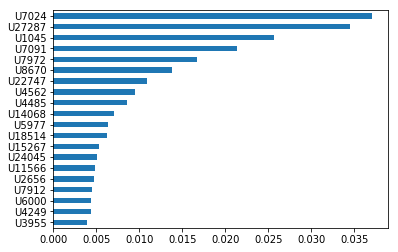

In [253]:
# plt.figure(num=None, figsize=(15, 15), dpi=100)
page_ranks = pd.Series(nx.algorithms.pagerank(G)).sort_values()
page_ranks.tail(20).plot(kind="barh")
plt.show()

In [268]:
page_ranks_nodes = []

In [269]:
for obj in page_ranks.tail(50).index:
    page_ranks_nodes.append(obj)

In [270]:
page_ranks_nodes

['U13959',
 'U7109',
 'U2136',
 'U14007',
 'U24504',
 'U8048',
 'U27471',
 'U25563',
 'U7355',
 'U12957',
 'U4456',
 'U4586',
 'U7319',
 'U9630',
 'U9126',
 'U2108',
 'U16127',
 'U8795',
 'U11591',
 'U10607',
 'U9657',
 'U2625',
 'U4568',
 'U2140',
 'U5982',
 'U13969',
 'U7987',
 'U9710',
 'U4448',
 'U13995',
 'U3955',
 'U4249',
 'U6000',
 'U7912',
 'U2656',
 'U11566',
 'U24045',
 'U15267',
 'U18514',
 'U5977',
 'U14068',
 'U4485',
 'U4562',
 'U22747',
 'U8670',
 'U7972',
 'U7091',
 'U1045',
 'U27287',
 'U7024']

In [274]:
page_ranks_bay=[]
for i in reversed(page_ranks_nodes):
    if i in nodes_bay:
        print("yes")
        page_ranks_bay.append(i)
print(page_ranks_bay)       

yes
yes
yes
yes
yes
yes
yes
['U27287', 'U15267', 'U11566', 'U2656', 'U4568', 'U2625', 'U4586']


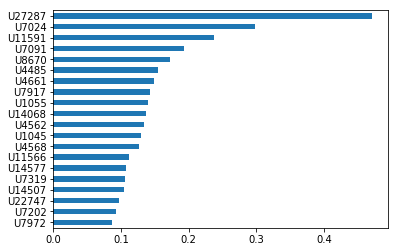

In [246]:
between = pd.Series(nx.betweenness_centrality(G)).sort_values()
between.tail(20).plot(kind="barh")
plt.show()

In [280]:
bt_nodes = []
for obj in between.tail(50).index:
    bt_nodes.append(obj)
print(bt_nodes)

['U24045', 'U2627', 'U13968', 'U9126', 'U15944', 'U13969', 'U3955', 'U15957', 'U16127', 'U9710', 'U18514', 'U4448', 'U2108', 'U15267', 'U4456', 'U2656', 'U19884', 'U6000', 'U7912', 'U19842', 'U7256', 'U8279', 'U19886', 'U14526', 'U5977', 'U14564', 'U14080', 'U8702', 'U7109', 'U24184', 'U7972', 'U7202', 'U22747', 'U14507', 'U7319', 'U14577', 'U11566', 'U4568', 'U1045', 'U4562', 'U14068', 'U1055', 'U7917', 'U4661', 'U4485', 'U8670', 'U7091', 'U11591', 'U7024', 'U27287']


In [281]:
bt_bay=[]
for j in reversed(bt_nodes):
    if j in nodes_bay:
        print("yes")
        bt_bay.append(j)
print(bt_bay) 

yes
yes
yes
yes
yes
yes
yes
['U27287', 'U4568', 'U11566', 'U8702', 'U2656', 'U15267', 'U2627']


In [282]:
most_influence = []
for pr in page_ranks_bay:
    if pr in bt_bay:
        most_influence.append(pr)
print(most_influence)

['U27287', 'U15267', 'U11566', 'U2656', 'U4568']


In [ ]:
sub_graph_00 = sub_graph_0.subgraph(comm_dict_0[0])
sub_graph_01 = sub_graph_0.subgraph(comm_dict_0[1])
sub_graph_02 = sub_graph_0.subgraph(comm_dict_0[2])
sub_graph_03 = sub_graph_0.subgraph(comm_dict_0[3])
sub_graph_04 = sub_graph_0.subgraph(comm_dict_0[4])

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_0.get(node) for node in sub_graph_00.nodes()]
pos=nx.spring_layout(sub_graph_0)
nx.draw_networkx_nodes(sub_graph_00, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_00, pos, alpha=0.5)
plt.title("Sub_graph_0")
plt.show()
# mod = c.modularity(partition_0,sub_graph_0)
# print("modularity:", mod)

In [ ]:
for c in sorted(nx.connected_components(sub_graph_00),key=len,reverse=True):
    print(c)

In [ ]:
print(list(nx.connected_components(sub_graph_00)))
print(list(nx.connected_components(sub_graph_01)))
print(list(nx.connected_components(sub_graph_02)))
print(list(nx.connected_components(sub_graph_03)))
print(list(nx.connected_components(sub_graph_04)))

In [ ]:
nx.triangles(sub_graph_0)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_1.get(node) for node in sub_graph_1.nodes()]
pos=nx.spring_layout(sub_graph_1)
nx.draw_networkx_nodes(sub_graph_1, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_1, pos, alpha=0.5)
plt.title("Sub_graph_1")
plt.show()
mod = c.modularity(partition_1,sub_graph_1)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_2.get(node) for node in sub_graph_2.nodes()]
pos=nx.spring_layout(sub_graph_2)
nx.draw_networkx_nodes(sub_graph_2, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_2, pos, alpha=0.5)
plt.title("Sub_graph_2")
plt.show()
mod = c.modularity(partition_2,sub_graph_2)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_3.get(node) for node in sub_graph_3.nodes()]
pos=nx.spring_layout(sub_graph_3)
nx.draw_networkx_nodes(sub_graph_3, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_3, pos, alpha=0.5)
plt.title("Sub_graph_3")
plt.show()
mod = c.modularity(partition_3,sub_graph_3)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_4.get(node) for node in sub_graph_4.nodes()]
pos=nx.spring_layout(sub_graph_4)
nx.draw_networkx_nodes(sub_graph_4, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_4, pos, alpha=0.5)
plt.title("Sub_graph_4")
plt.show()
mod = c.modularity(partition_4,sub_graph_4)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_5.get(node) for node in sub_graph_5.nodes()]
pos=nx.spring_layout(sub_graph_5)
nx.draw_networkx_nodes(sub_graph_5, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_5, pos, alpha=0.5)
plt.title("Sub_graph_5")
plt.show()
mod = c.modularity(partition_5,sub_graph_5)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_6.get(node) for node in sub_graph_6.nodes()]
pos=nx.spring_layout(sub_graph_6)
nx.draw_networkx_nodes(sub_graph_6, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_6, pos, alpha=0.5)
plt.title("Sub_graph_6")
plt.show()
mod = c.modularity(partition_6,sub_graph_6)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_7.get(node) for node in sub_graph_7.nodes()]
pos=nx.spring_layout(sub_graph_7)
nx.draw_networkx_nodes(sub_graph_7, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_7, pos, alpha=0.5)
plt.title("Sub_graph_7")
plt.show()
mod = c.modularity(partition_7,sub_graph_7)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_8.get(node) for node in sub_graph_8.nodes()]
pos=nx.spring_layout(sub_graph_8)
nx.draw_networkx_nodes(sub_graph_8, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_8, pos, alpha=0.5)
plt.title("Sub_graph_8")
plt.show()
mod = c.modularity(partition_8,sub_graph_8)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_9.get(node) for node in sub_graph_9.nodes()]
pos=nx.spring_layout(sub_graph_9)
nx.draw_networkx_nodes(sub_graph_9, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_9, pos, alpha=0.5)
plt.title("Sub_graph_9")
plt.show()
mod = c.modularity(partition_9,sub_graph_9)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_10.get(node) for node in sub_graph_10.nodes()]
pos=nx.spring_layout(sub_graph_10)
nx.draw_networkx_nodes(sub_graph_10, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_10, pos, alpha=0.5)
plt.title("Sub_graph_10")
plt.show()
mod = c.modularity(partition_10,sub_graph_10)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_11.get(node) for node in sub_graph_11.nodes()]
pos=nx.spring_layout(sub_graph_11)
nx.draw_networkx_nodes(sub_graph_11, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_11, pos, alpha=0.5)
plt.title("Sub_graph_11")
plt.show()
mod = c.modularity(partition_11,sub_graph_11)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_12.get(node) for node in sub_graph_12.nodes()]
pos=nx.spring_layout(sub_graph_12)
nx.draw_networkx_nodes(sub_graph_12, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_12, pos, alpha=0.5)
plt.title("Sub_graph_12")
plt.show()
mod = c.modularity(partition_12,sub_graph_12)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_13.get(node) for node in sub_graph_13.nodes()]
pos=nx.spring_layout(sub_graph_13)
nx.draw_networkx_nodes(sub_graph_13, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_13, pos, alpha=0.5)
plt.title("Sub_graph_13")
plt.show()
mod = c.modularity(partition_13,sub_graph_13)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_14.get(node) for node in sub_graph_14.nodes()]
pos=nx.spring_layout(sub_graph_14)
nx.draw_networkx_nodes(sub_graph_14, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_14, pos, alpha=0.5)
plt.title("Sub_graph_14")
plt.show()
mod = c.modularity(partition_14,sub_graph_14)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_15.get(node) for node in sub_graph_15.nodes()]
pos=nx.spring_layout(sub_graph_15)
nx.draw_networkx_nodes(sub_graph_15, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_15, pos, alpha=0.5)
plt.title("Sub_graph_15")
plt.show()
mod = c.modularity(partition_15,sub_graph_15)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_16.get(node) for node in sub_graph_16.nodes()]
pos=nx.spring_layout(sub_graph_16)
nx.draw_networkx_nodes(sub_graph_16, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_16, pos, alpha=0.5)
plt.title("Sub_graph_16")
plt.show()
mod = c.modularity(partition_16,sub_graph_16)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_17.get(node) for node in sub_graph_17.nodes()]
pos=nx.spring_layout(sub_graph_17)
nx.draw_networkx_nodes(sub_graph_17, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_17, pos, alpha=0.5)
plt.title("Sub_graph_17")
plt.show()
mod = c.modularity(partition_17,sub_graph_17)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_18.get(node) for node in sub_graph_18.nodes()]
pos=nx.spring_layout(sub_graph_18)
nx.draw_networkx_nodes(sub_graph_18, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_18, pos, alpha=0.5)
plt.title("Sub_graph_18")
plt.show()
mod = c.modularity(partition_18,sub_graph_18)
print("modularity:", mod)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition_19.get(node) for node in sub_graph_19.nodes()]
pos=nx.spring_layout(sub_graph_19)
nx.draw_networkx_nodes(sub_graph_19, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(sub_graph_19, pos, alpha=0.5)
plt.title("Sub_graph_19")
plt.show()
mod = c.modularity(partition_19,sub_graph_19)
print("modularity:", mod)

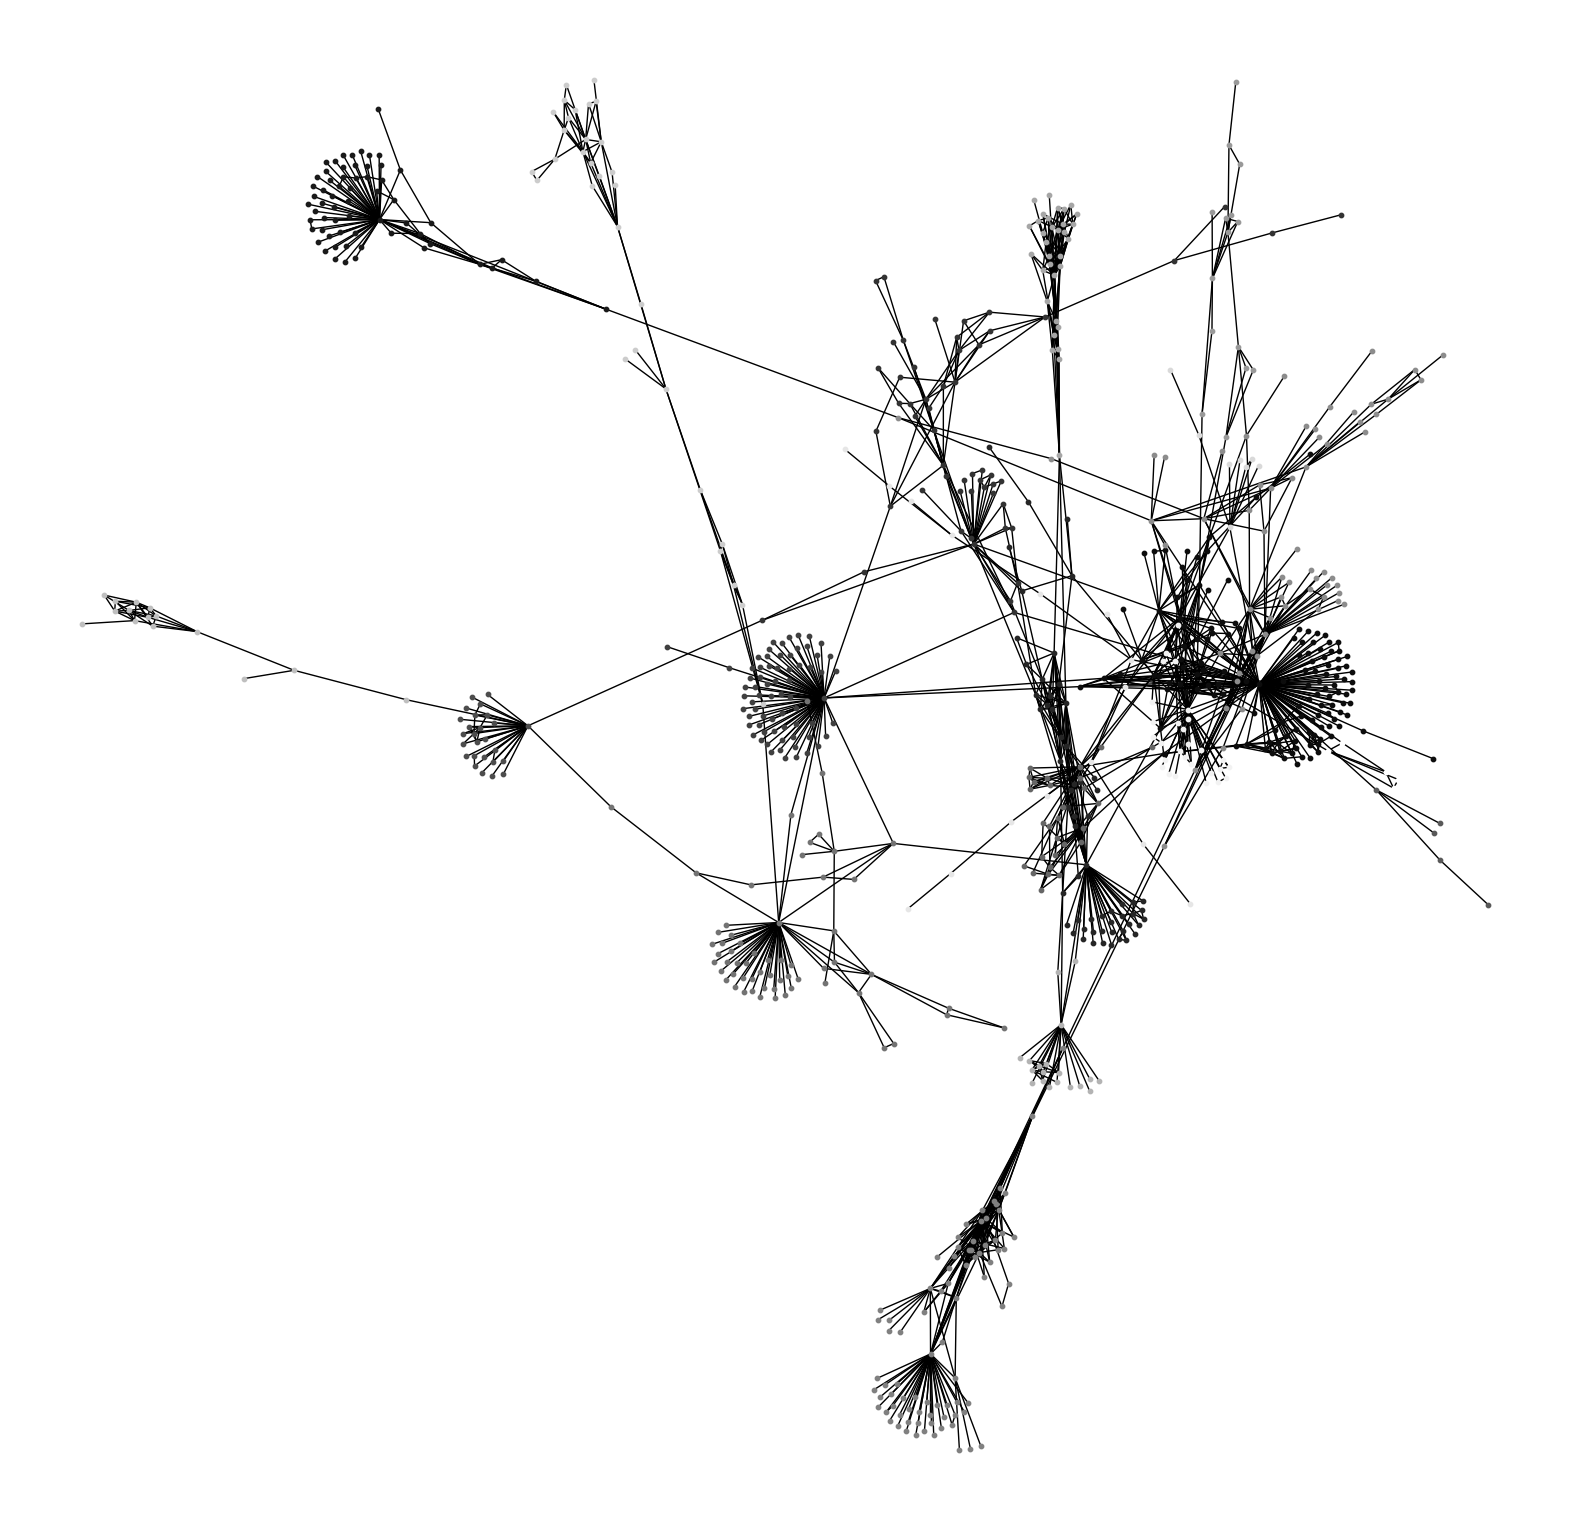

modularity: 0.859905411249725


In [101]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 10,
                                node_color = str(count/ size))
nx.draw_networkx_edges(G, pos, alpha=1)
plt.show()
mod = c.modularity(partition,G)
print("modularity:", mod)

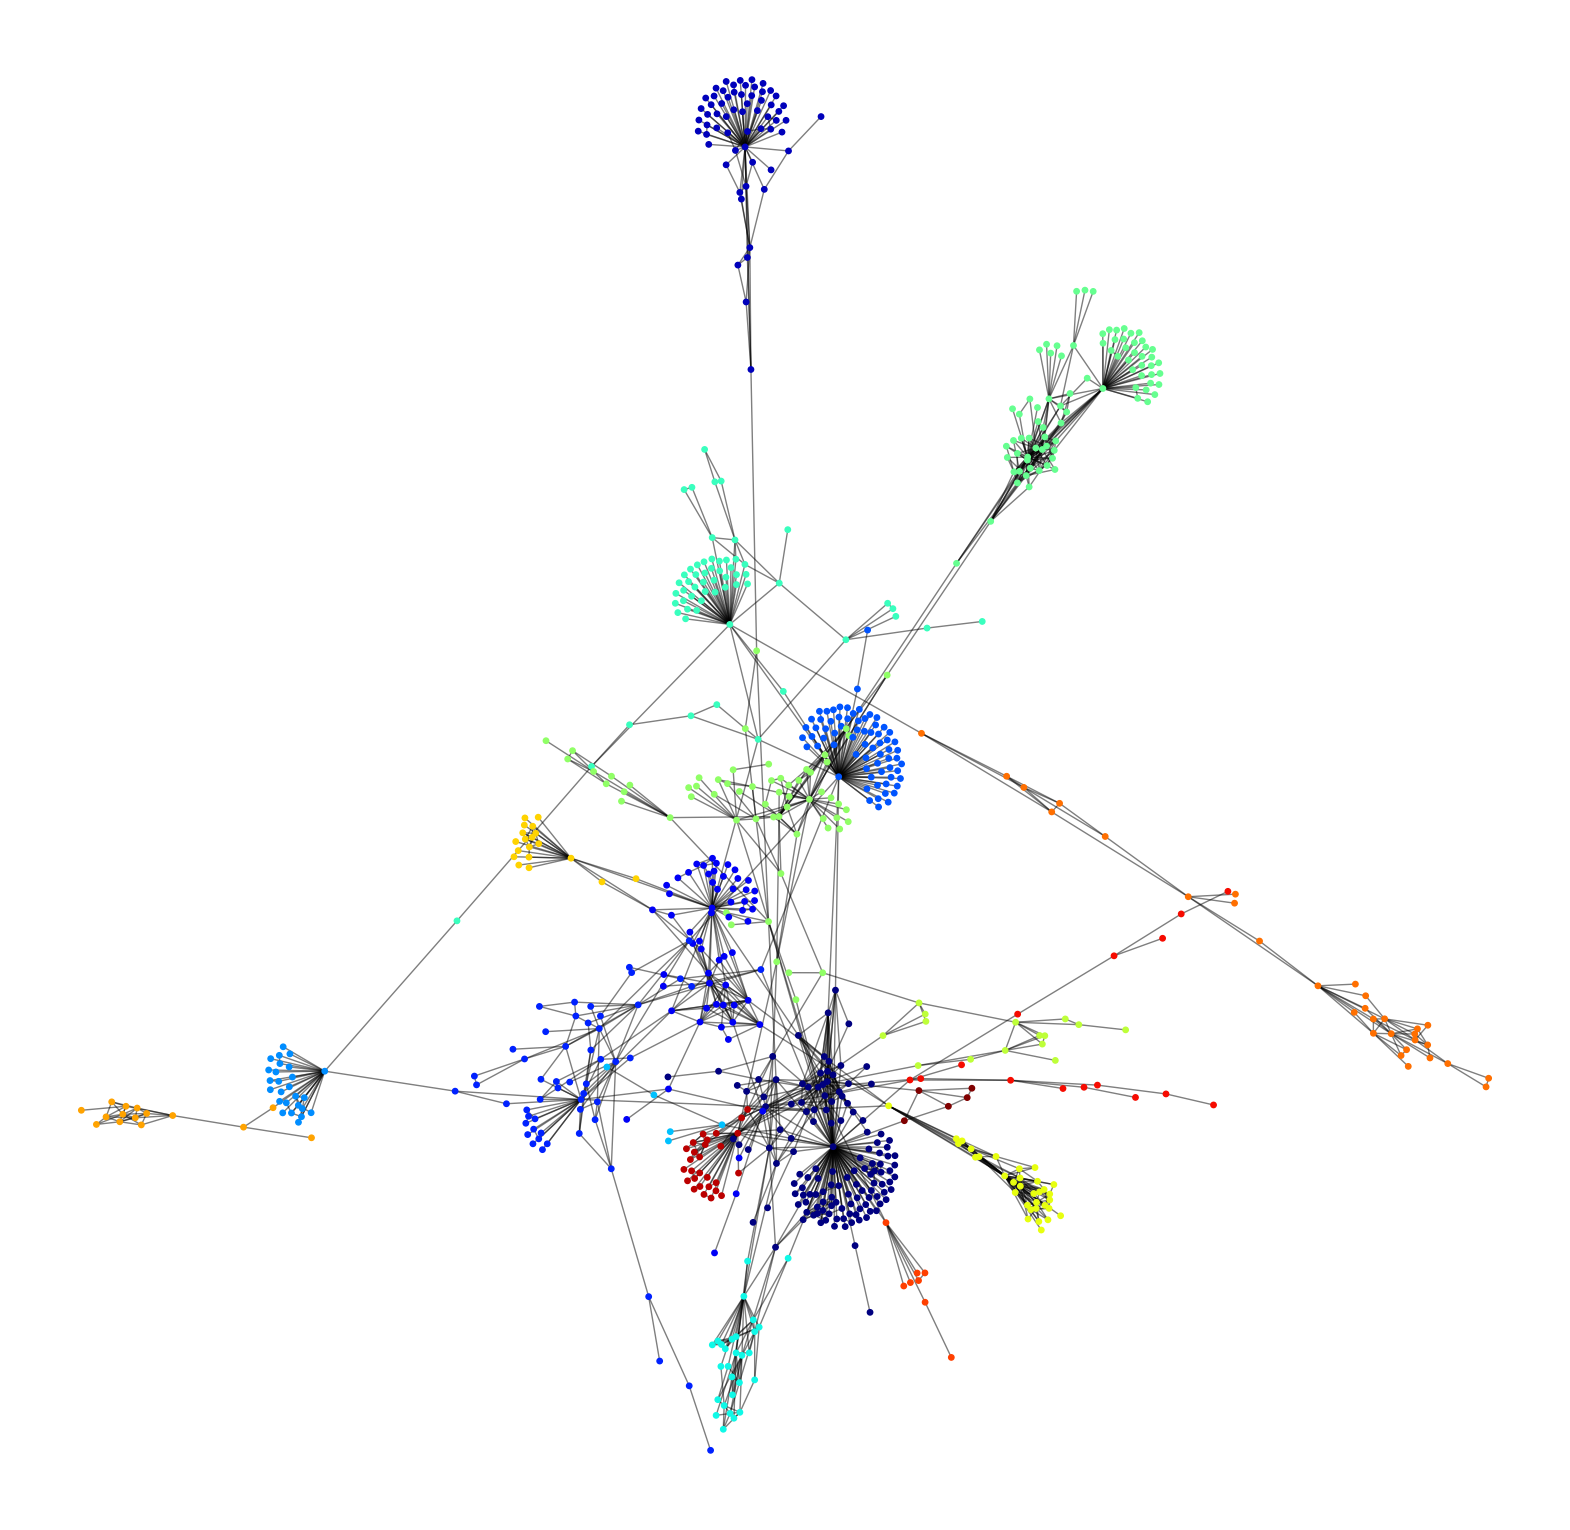

NameError: name 'community' is not defined

In [102]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition.get(node) for node in G.nodes()]
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
mod = community.modularity(partition,G)
print("modularity:", mod)

In [ ]:
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)